# Heat-exchanger data analysis and engineering calcs (Cristian Merli, UniTn id: 211384)

## Environment setup and parameters

### - General software info

* Useful links:

https://code.visualstudio.com/docs/datascience/data-science-tutorial

* SW header:

In [1]:
__author__ = "Cristian Merli"
__copyright__ = "Copyright 2022, Cristian Merli"
__credits__ = ["Cristian Merli", "Ing. M.G."]
__license__ = "GPL"
__version__ = "2.0.0"
__maintainer__ = "Cristian Merli"
__email__ = "cristian.merli@studenti.unitn.it"
__status__ = "Working on engineering-calcs"

### - Clear envirnoment

* Clear JupyterNotebook environment and set python files auto-reload

In [2]:
%reset -f
%load_ext autoreload
%autoreload 2

### - Libraries import

* Import project personal libraries

In [3]:
from libs import plotting_lib as pl           # Plotting lib
from libs import data_analysis_lib as da      # Data analysis lib
from libs import thermophys_vars_lib as tv    # Thermophysical variables lib
from libs import eng_calcs_lib as ec          # Engineering calcs lib
from libs import output_lib as out            # Output lib

### - Load personalized plotting style

* Load personalized plotting style calling dedicated initialization function

In [4]:
pl.init_plt_style()   # Function call to load and init personalized plotting style

### - Flags and parameters

* Plotting flags

In [5]:
measures_plt_flg = True           # Measures plotting flag (set to True in order to plot)
sc_win_plt_flg = True             # Steady-conditions data windows plotting flag (set to True in order to plot)
thermophys_vars_plt_flg = True    # Thermophysical variables plotting flag (set to True in order to plot)

* Debug flags (must be enabled to save defined output text into output files)

In [6]:
measures_dbg_flg = True     # Measures debug flag (set to True in order to plot)
sc_win_dbg_flg = True       # Find steady-conditions data-windows debug flag (set to True in order to consult output)
mean_vals_dbg_flg = True    # Measures mean vals debug flag (set to True in order to consult output)
he_dbg_flg = True           # Heat-exchanger properties debug flag (set to True in order to consult output)
meas_calcs_dbg_flg = True   # Measures and calcs results debug flag (set to True in order to consult output)

* Parameters

In [7]:
sc_win_span = 90      # Steady-conditions data-windows span (in samples)
use_re_alt = False    # Use alternative way to calculate Reynolds asimensional numbers: using volume flow rate to calculate fluid velocity, pipe equivalent diameter and fluid kinematic viscosity

## Heat-exchanger data analysis

### - Data import, extraction and filtering

* Import dataset's data from formatted (.csv) file, creating a new 'DataFrame' variable --> Source: Lab-data taken the 26th Nov 2021, group number 5 (original file name: scambiatore26112021_5.dat)

In [8]:
he_data = da.load_dataset_data()    # Function call to format dataset and import data from (.csv) file, creating a new panda DataFrame variable

* Find different measures data and different measures delimiting-indexes in dataset 'DataFrame' saving measures delimiteing-indexes in output file


--> Measures-delimiting indexes: [195, 402, 430, 629, 689, 912, 939, 1197]



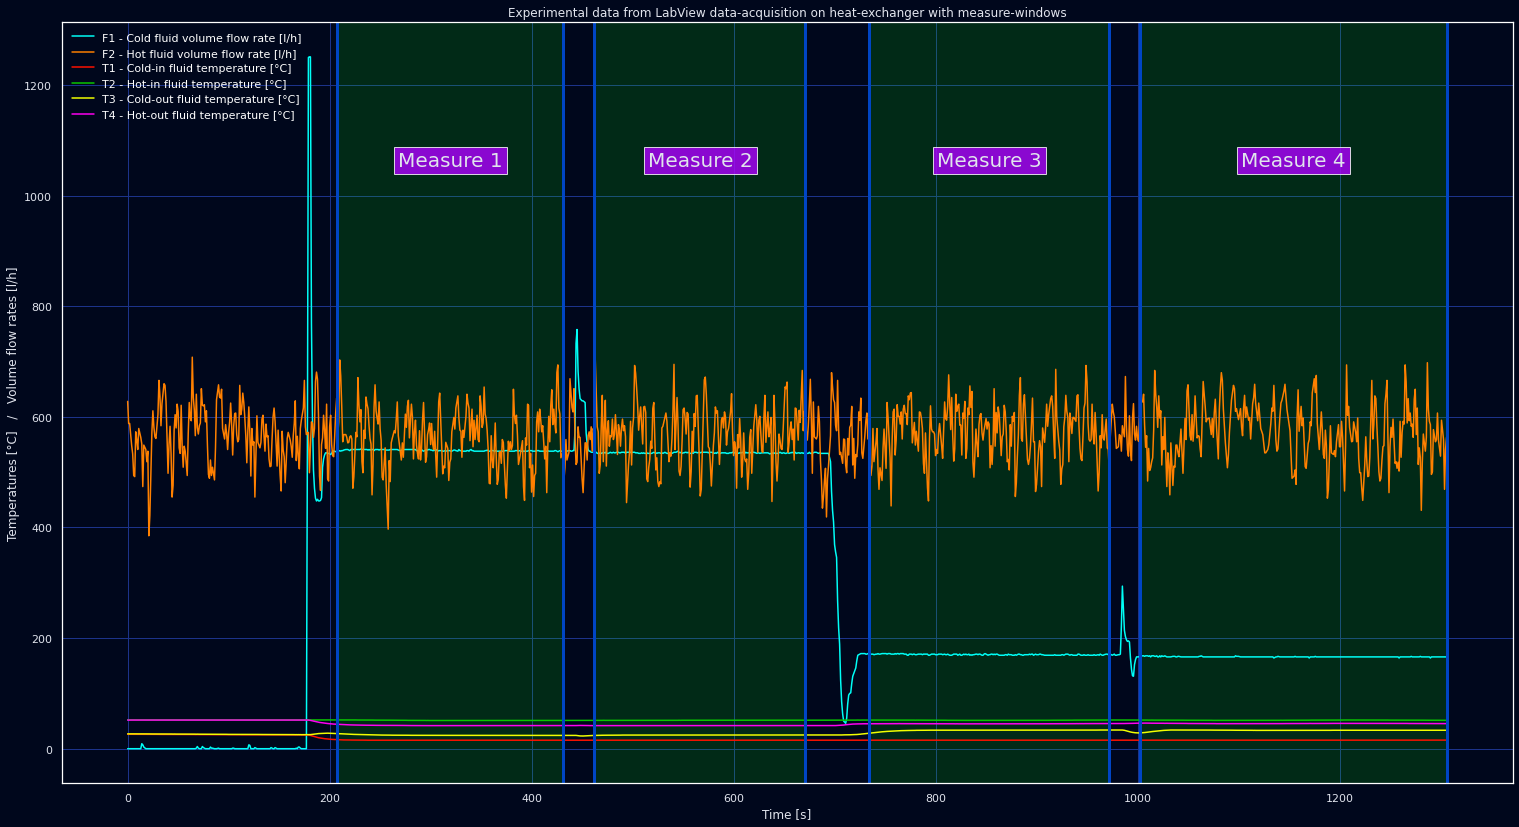

<Figure size 1872x1008 with 0 Axes>

In [9]:
he_measures_data, delim_idxs = da.find_plt_save_measures(he_data, measures_plt_flg, measures_dbg_flg)   # Function call to find and plot temperatures/volume flow rates, taken during LabView data-acquisition on heat-exchanger, saving delimiting idxs

* Create data-windows list with optimal steady-conditions for each measure (data-windows span in samples, defined in parameters section) saving std-devs output in output file


-----------------------------------------------------------------------
--> NEW 'find_stdy_cond()' FUNCTION CALL FOR Measure 1
-----------------------------------------------------------------------

f1_stddev: 1.1240754280918839
f2_stddev: 47.495766287438315
t1_stddev: 0.03535092488376105
t2_stddev: 0.30036922763303214
t3_stddev: 0.2840200094936256
t4_stddev: 0.2679361403038012
mean_stddev: 8.25125300297407

f1_stddev: 0.6103559060784889
f2_stddev: 52.591290345690496
t1_stddev: 0.04845941195208172
t2_stddev: 0.08074528004588409
t3_stddev: 0.06258916236811773
t4_stddev: 0.05811220796104254
mean_stddev: 8.908592052349352

min_stddevs_datablocks_idx: 0

-----------------------------------------------------------------------
--> NEW 'find_stdy_cond()' FUNCTION CALL FOR Measure 2
-----------------------------------------------------------------------

f1_stddev: 0.8637519410862924
f2_stddev: 55.477547729891114
t1_stddev: 0.04229142105240371
t2_stddev: 0.03553690209819346
t3_stddev: 0.0716

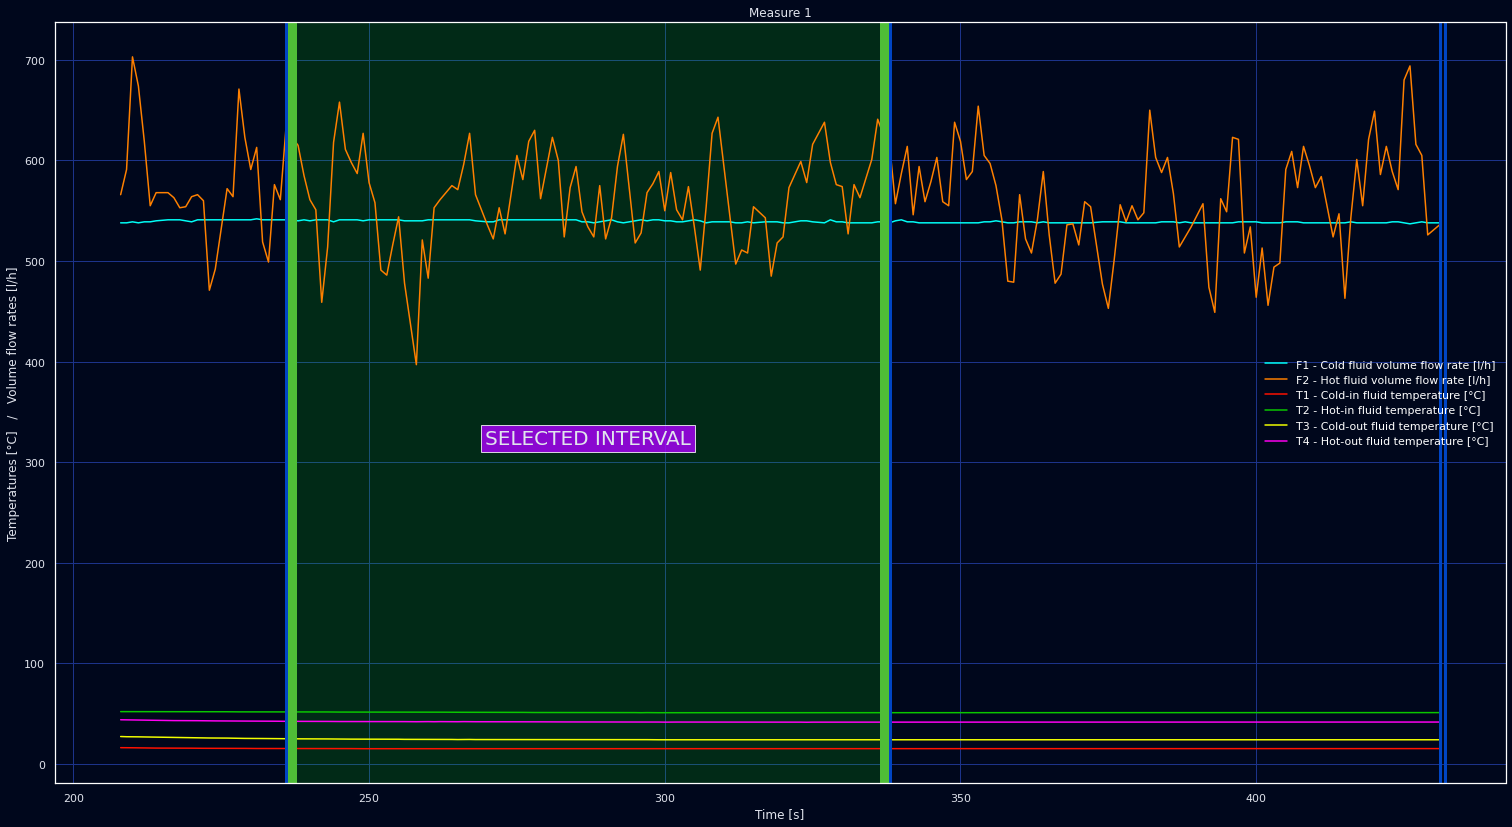

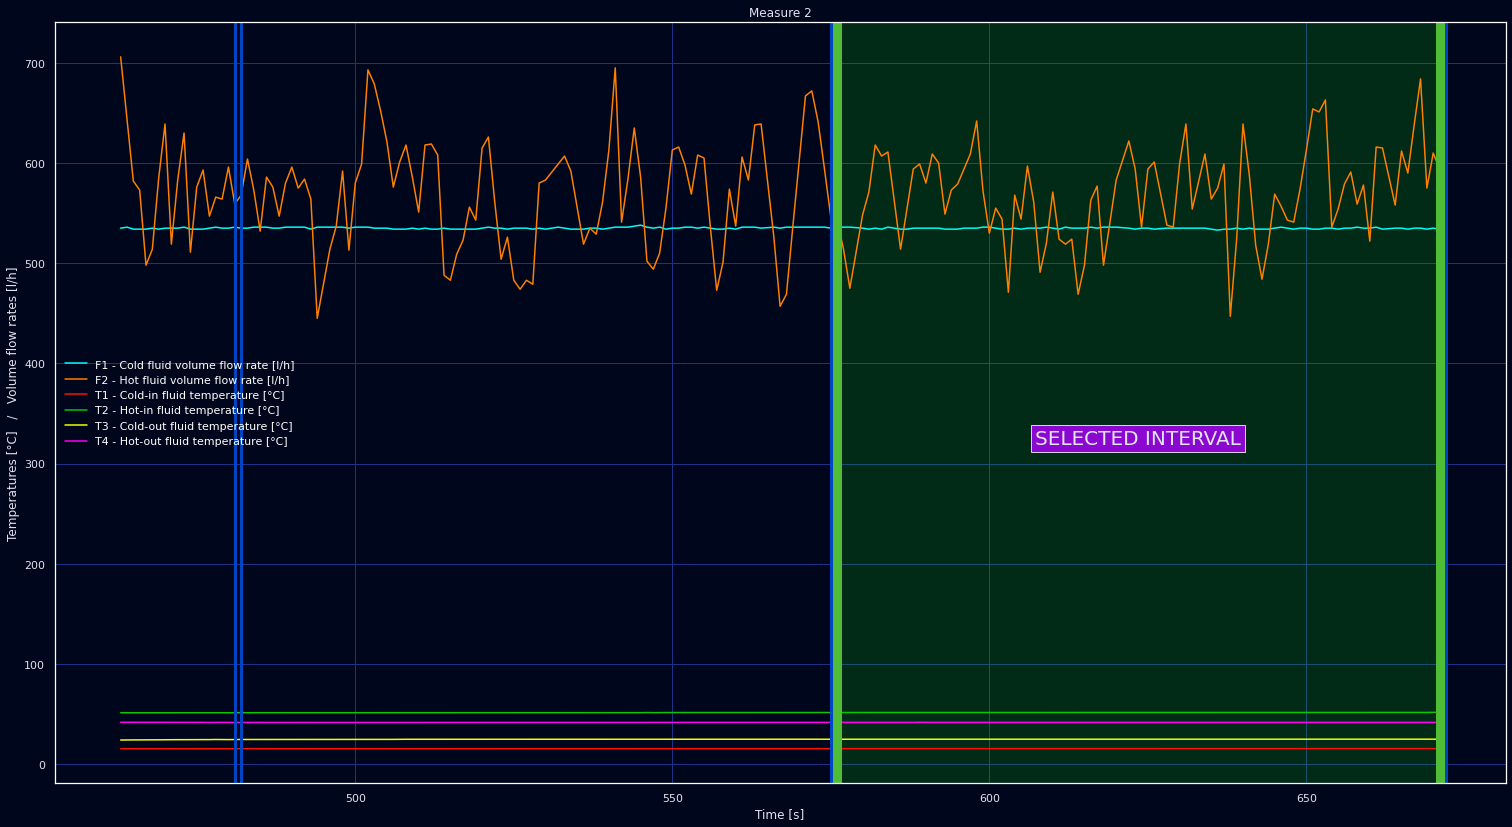

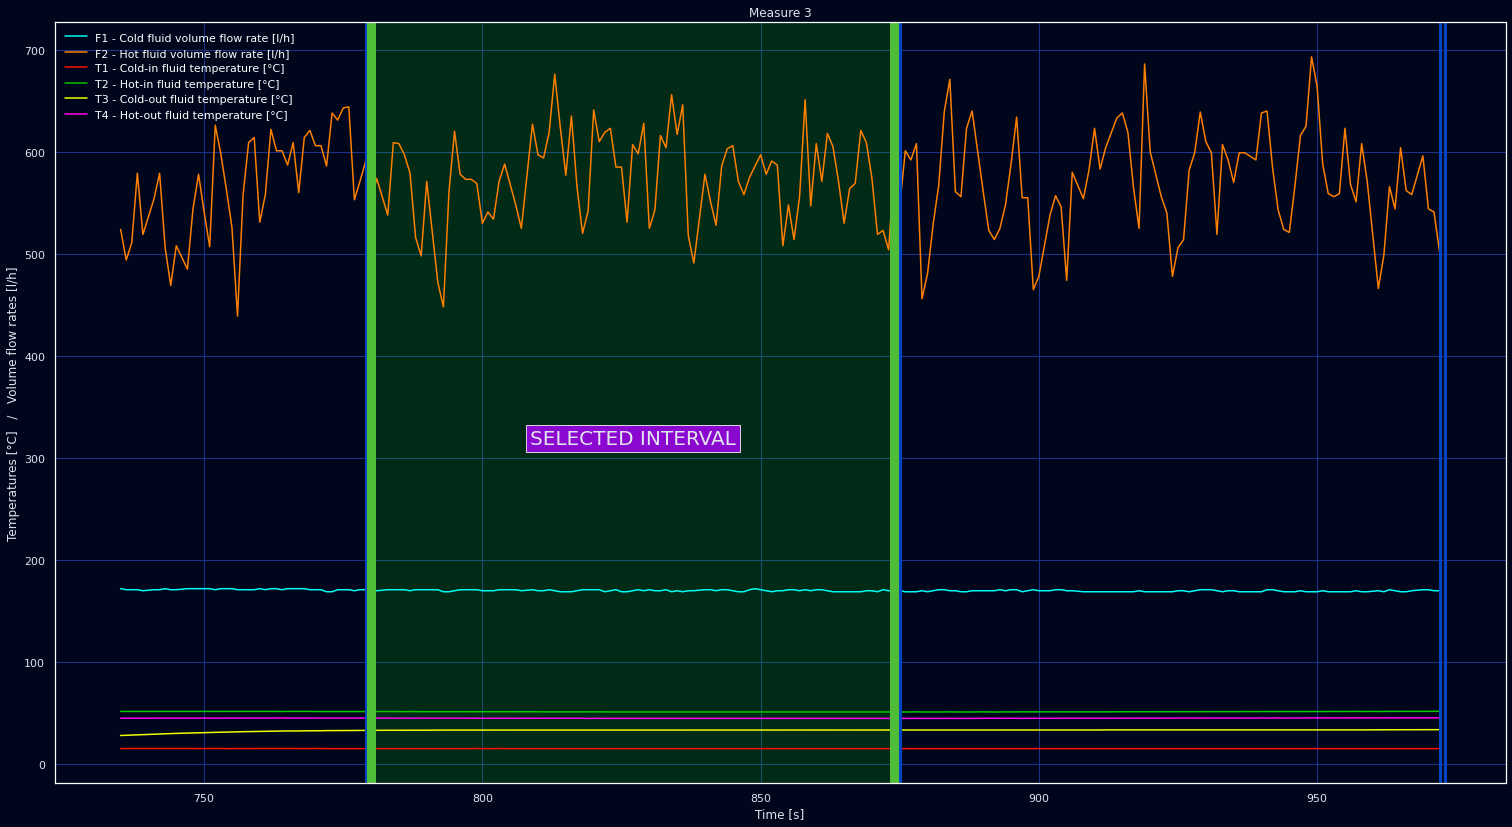

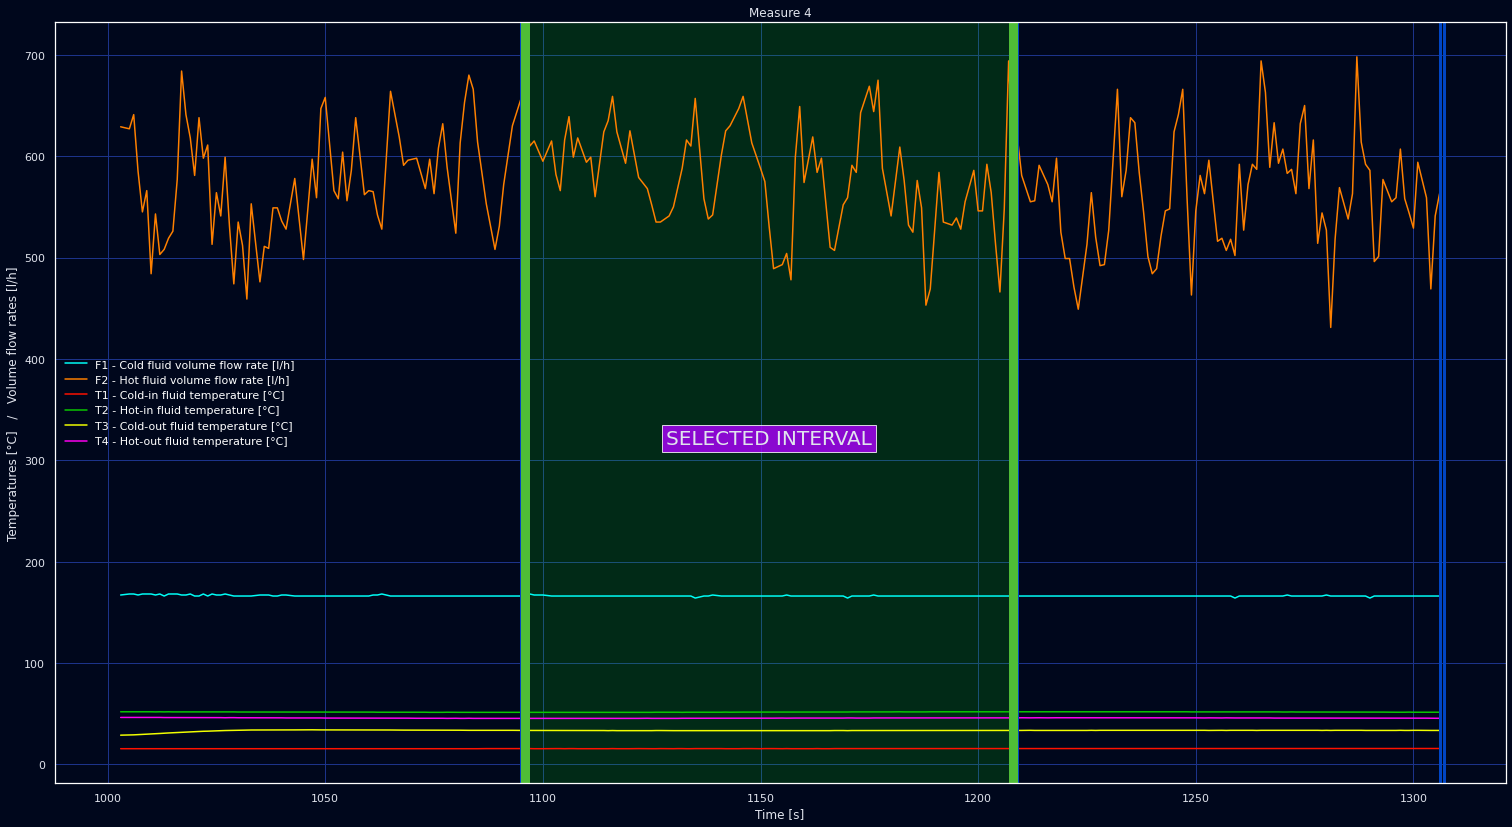

<Figure size 1872x1008 with 0 Axes>

In [10]:
sc_windows = da.find_plt_save_stdy_cond_win(he_measures_data, sc_win_span, sc_win_plt_flg, sc_win_dbg_flg)    # Function call to find, plot and save steady-conditions data windows info

### - Measured variables definition and measures objects list creation

* Determine measured variables by calculating mean value in optimal steady-conditions data-windows, define measures list to contain each measure's calculated/measured data and save measures in output file

In [11]:
measures = da.def_save_meas_vars(sc_windows, mean_vals_dbg_flg)   # Function call to determine measured data, define measures data-structures list and save measures data


--> Cocurrent measure 1 mean vals:
F1: 539.9222222222222 [l/h]
F2: 562.5222222222222 [l/h]
T1: 15.254444444444452 [°C]
T2: 51.24088888888886 [°C]
T3: 24.349777777777817 [°C]
T4: 41.90299999999992 [°C]

--> Countercurrent measure 1 mean vals:
F1: 534.8333333333334 [l/h]
F2: 568.4111111111112 [l/h]
T1: 15.413333333333329 [°C]
T2: 51.51888888888898 [°C]
T3: 24.821111111111083 [°C]
T4: 41.686666666666596 [°C]

--> Countercurrent measure 2 mean vals:
F1: 170.2111111111111 [l/h]
F2: 574.2333333333333 [l/h]
T1: 15.33355555555554 [°C]
T2: 51.29666666666669 [°C]
T3: 33.513222222222204 [°C]
T4: 45.01066666666657 [°C]

--> Cocurrent measure 2 mean vals:
F1: 166.03333333333333 [l/h]
F2: 578.8333333333334 [l/h]
T1: 15.414222222222243 [°C]
T2: 51.46877777777776 [°C]
T3: 33.24355555555555 [°C]
T4: 45.49700000000002 [°C]



## Thermophysical variables

### - Data import

* Import thermophysical variables data from (.csv) table files, creating 'DataFrames' variables --> Source: moodle-pdf (original file name: Proprietà termofisiche aria e acqua.pdf), http://www.inductor-jmag.ru/files/content/a129160.pdf - pdf page 28 / page 21 - Table 4 and https://nvlpubs.nist.gov/nistpubs/Legacy/RPT/nbsreport7836.pdf - pdf page 39 / page 16

In [12]:
air_atmp, water, aisi_316, pyrex_glass = tv.load_thermophys_vars_data()   # Function call to load thermophysical vars from (.csv) table files, creating new pandas DataFrames variables

### - Air's thermophysical variables polynomial approximation (at atm pressure) 

* Function call to apply air's thermophysical variables polynomial approximation and plotting vs temperature (at atmospheric pressure)

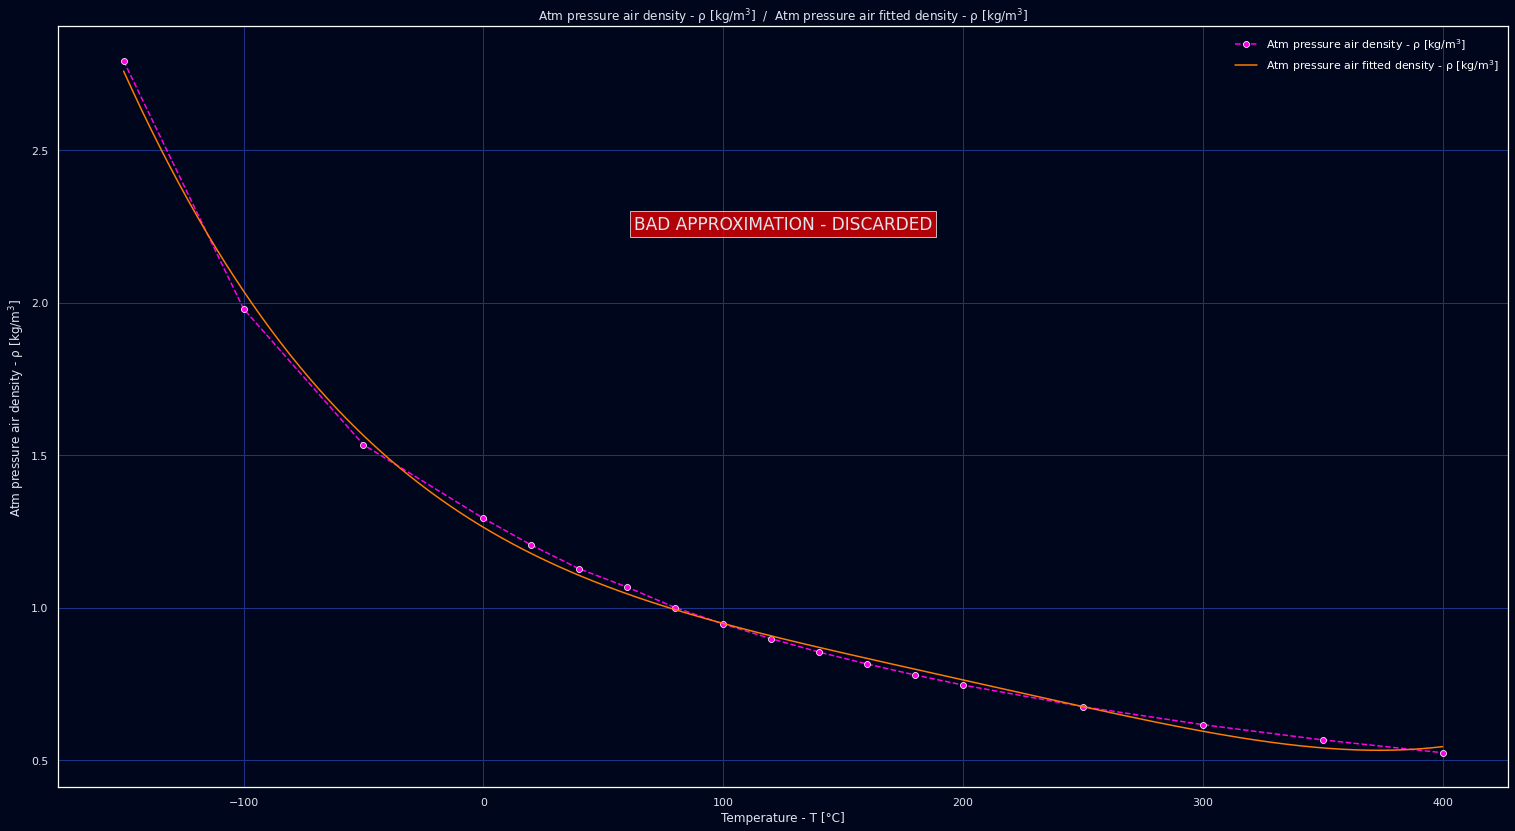

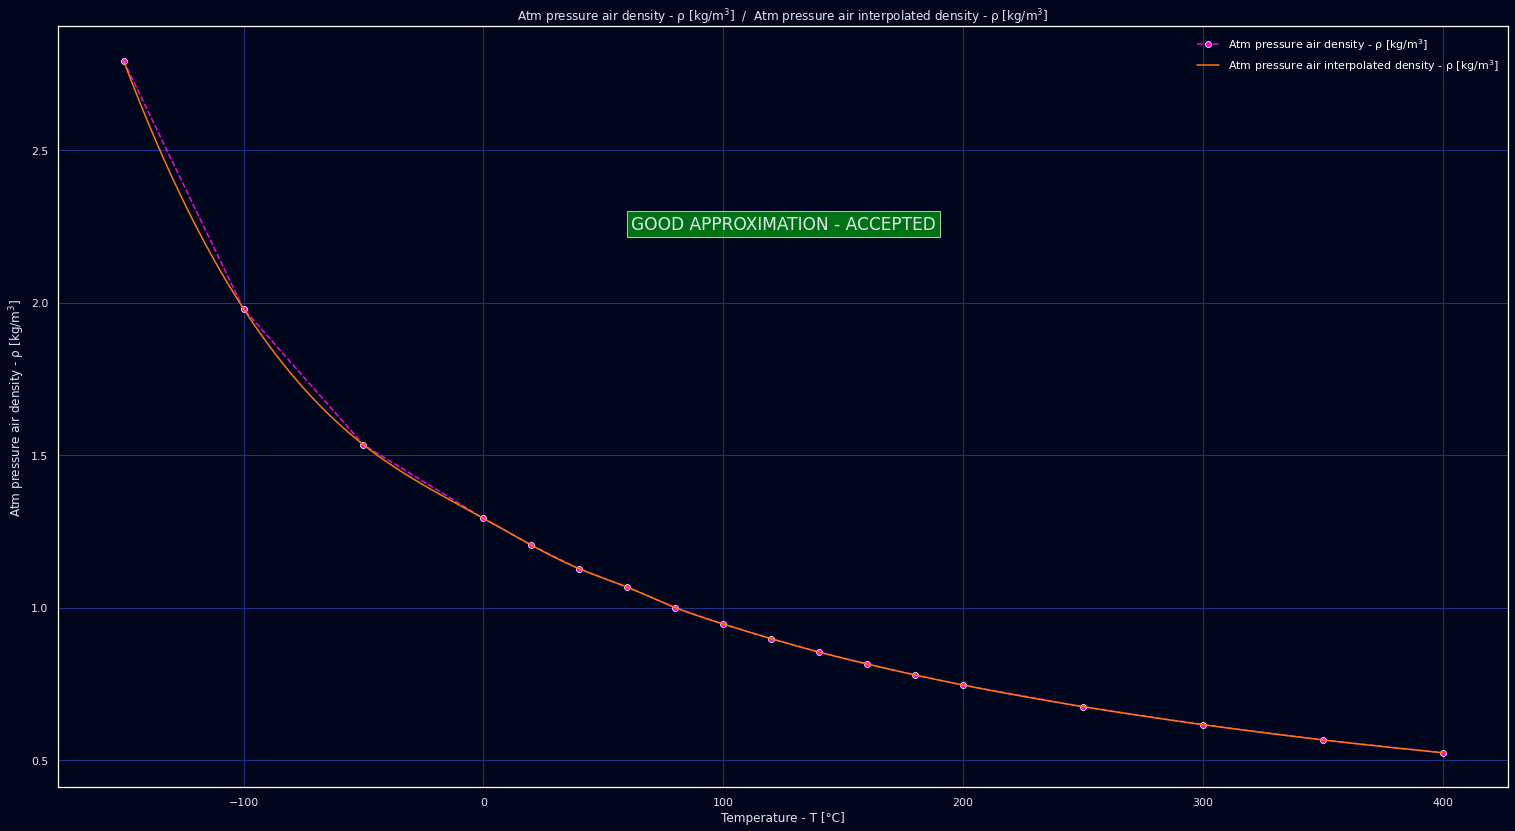

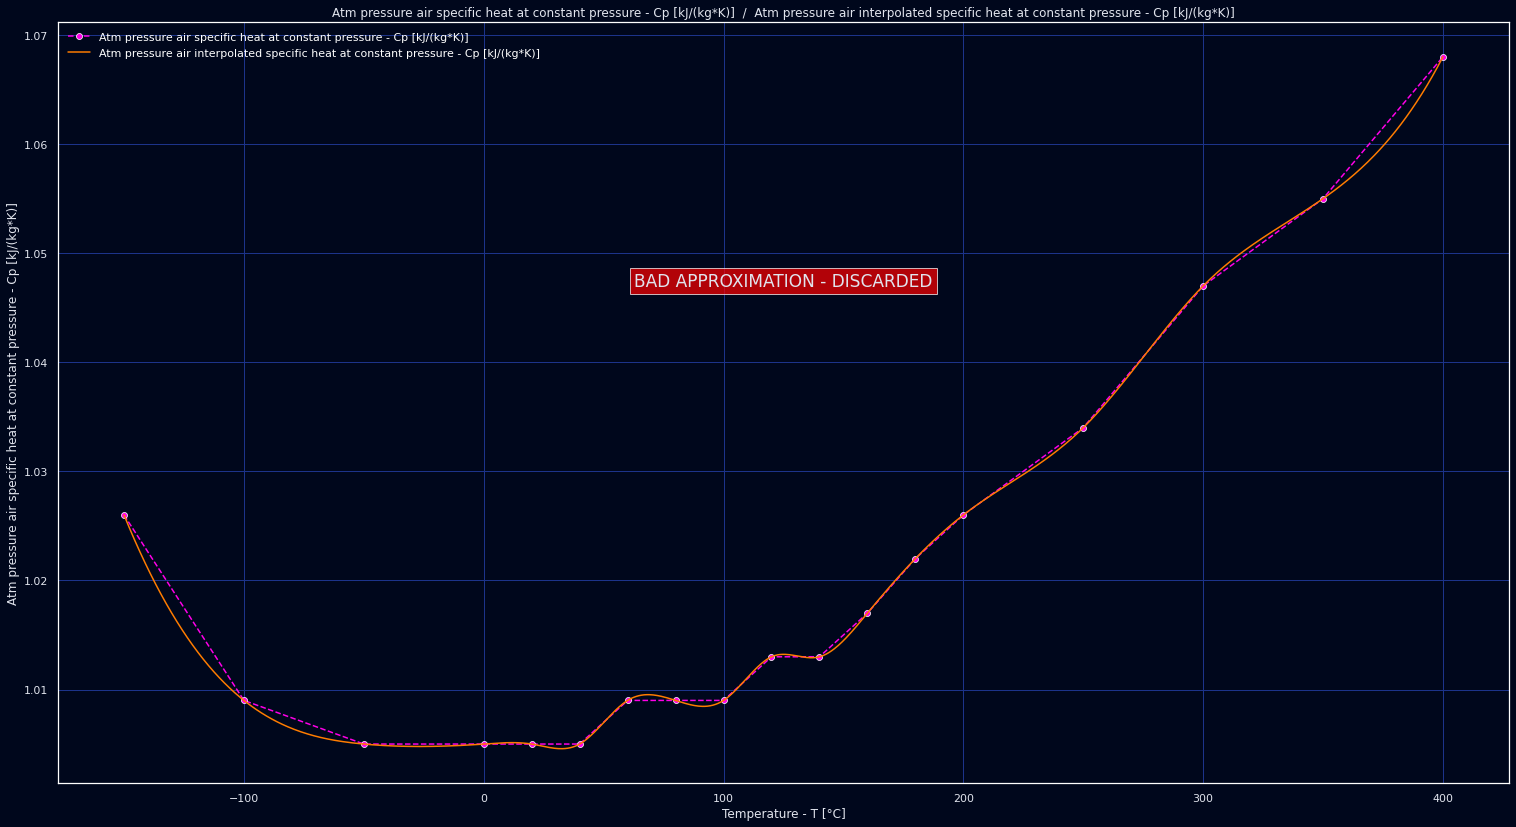

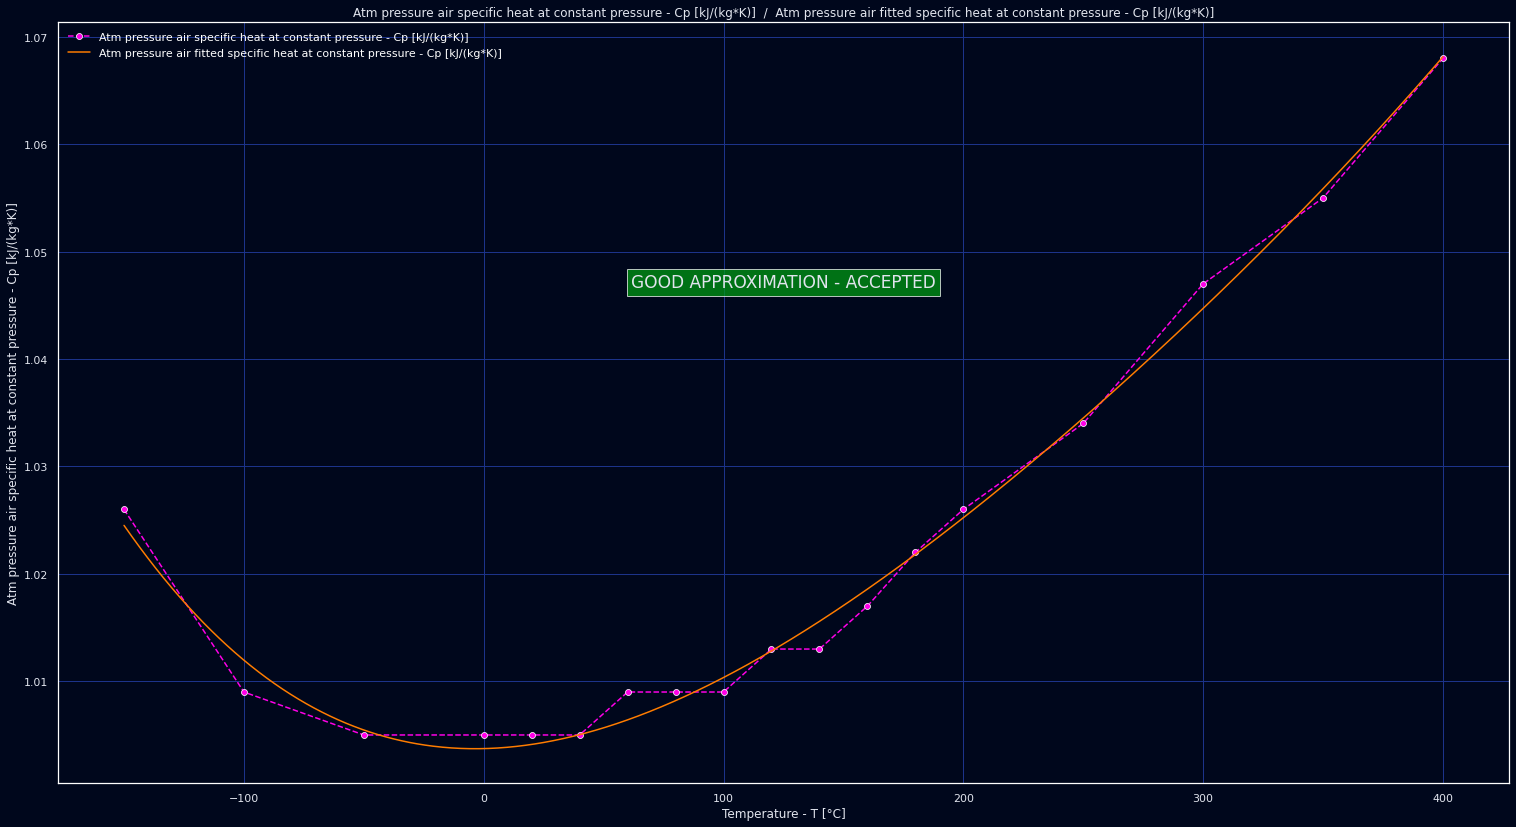

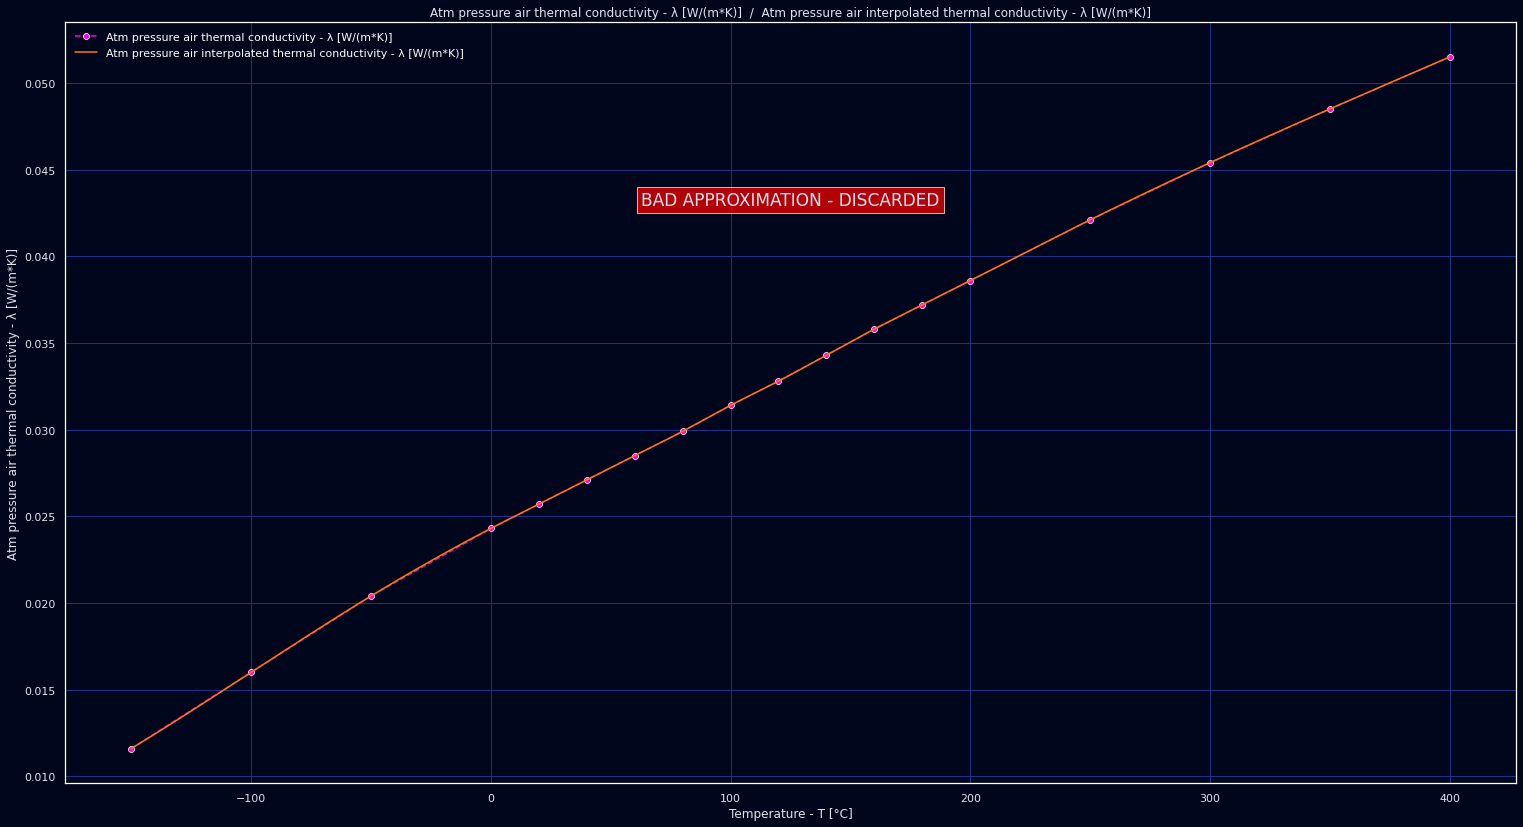

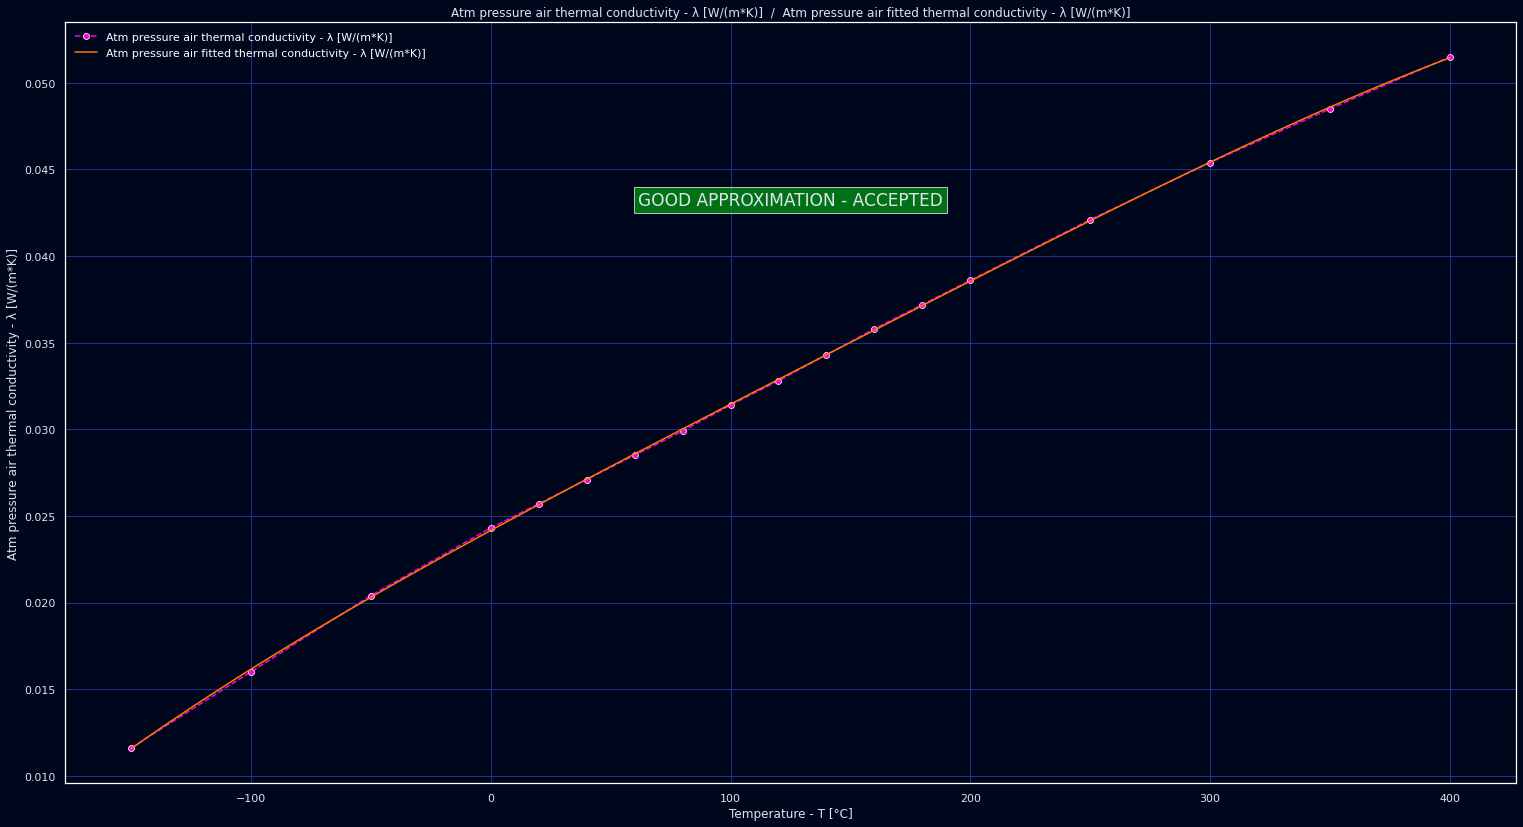

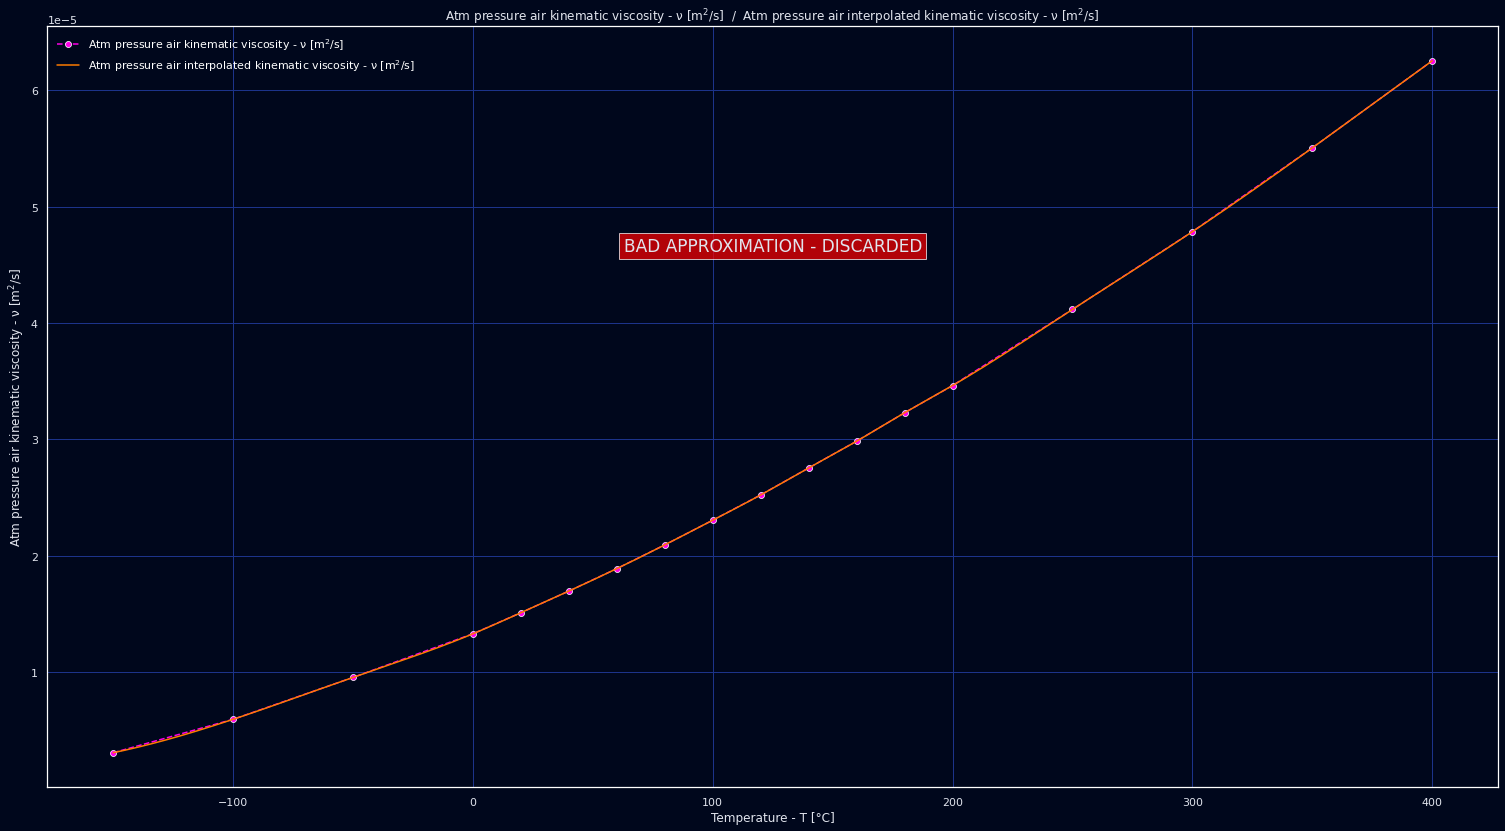

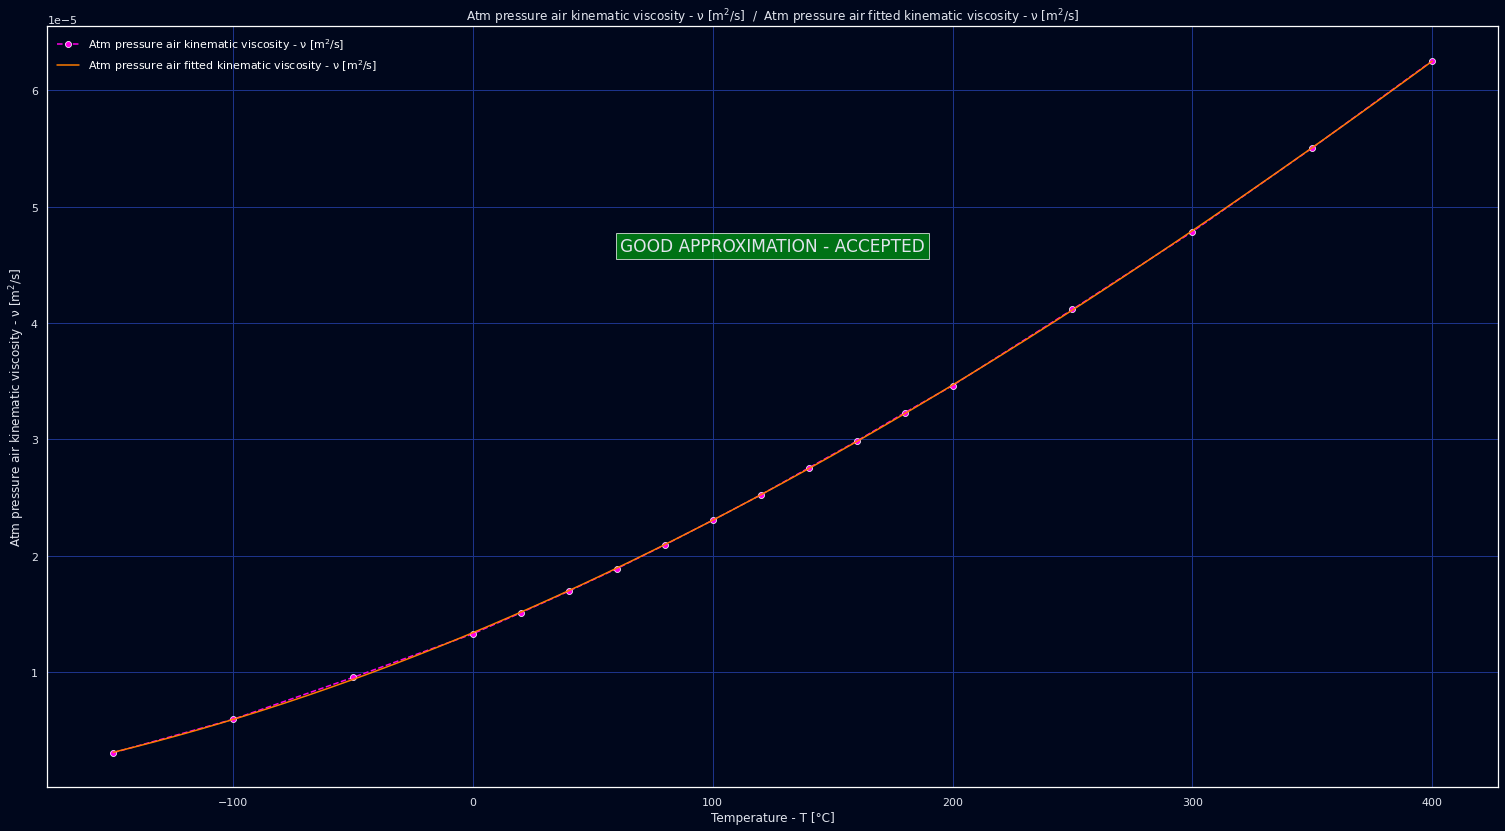

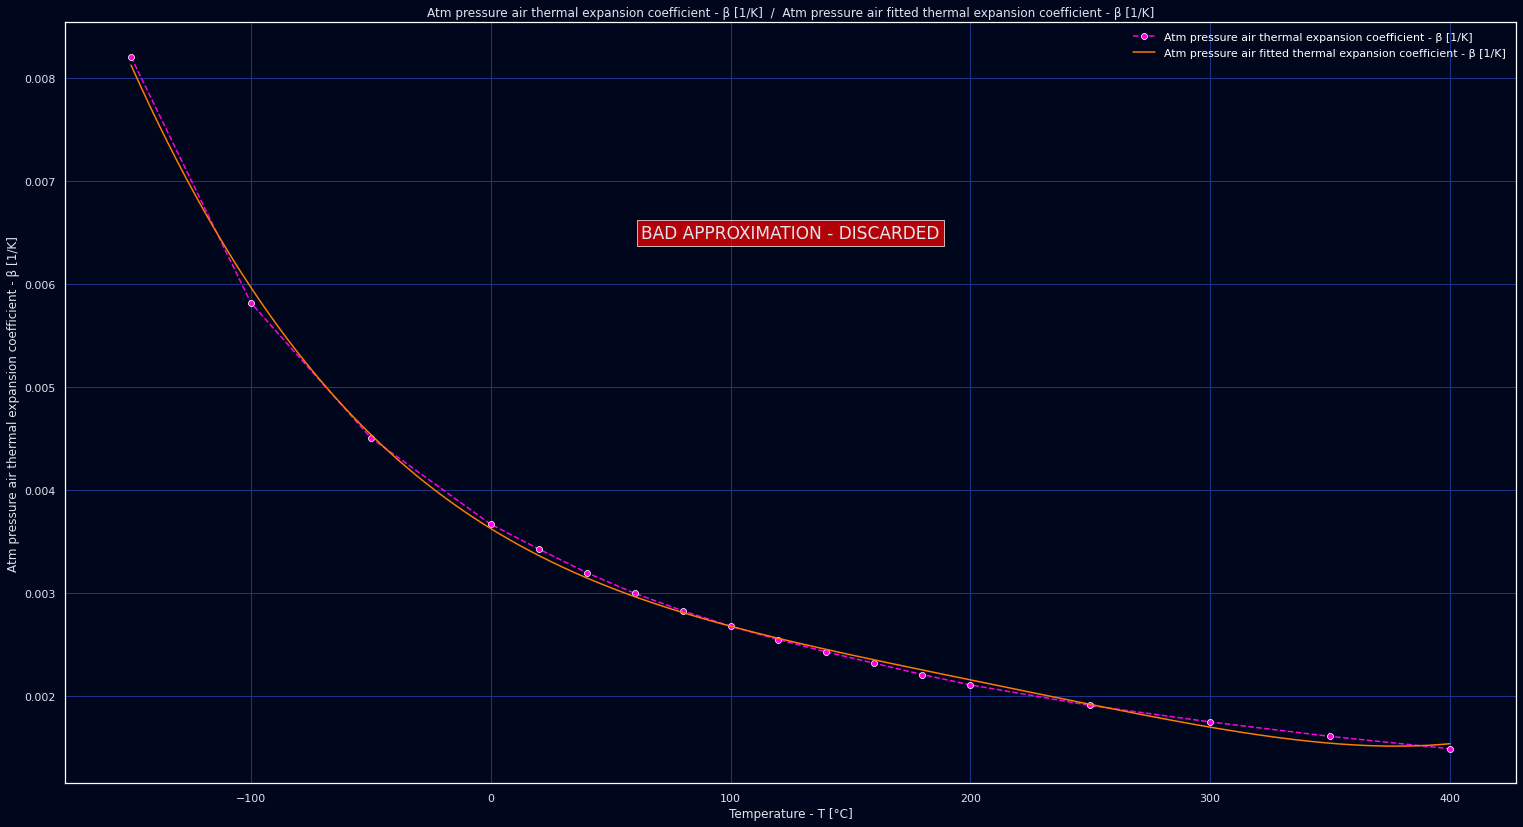

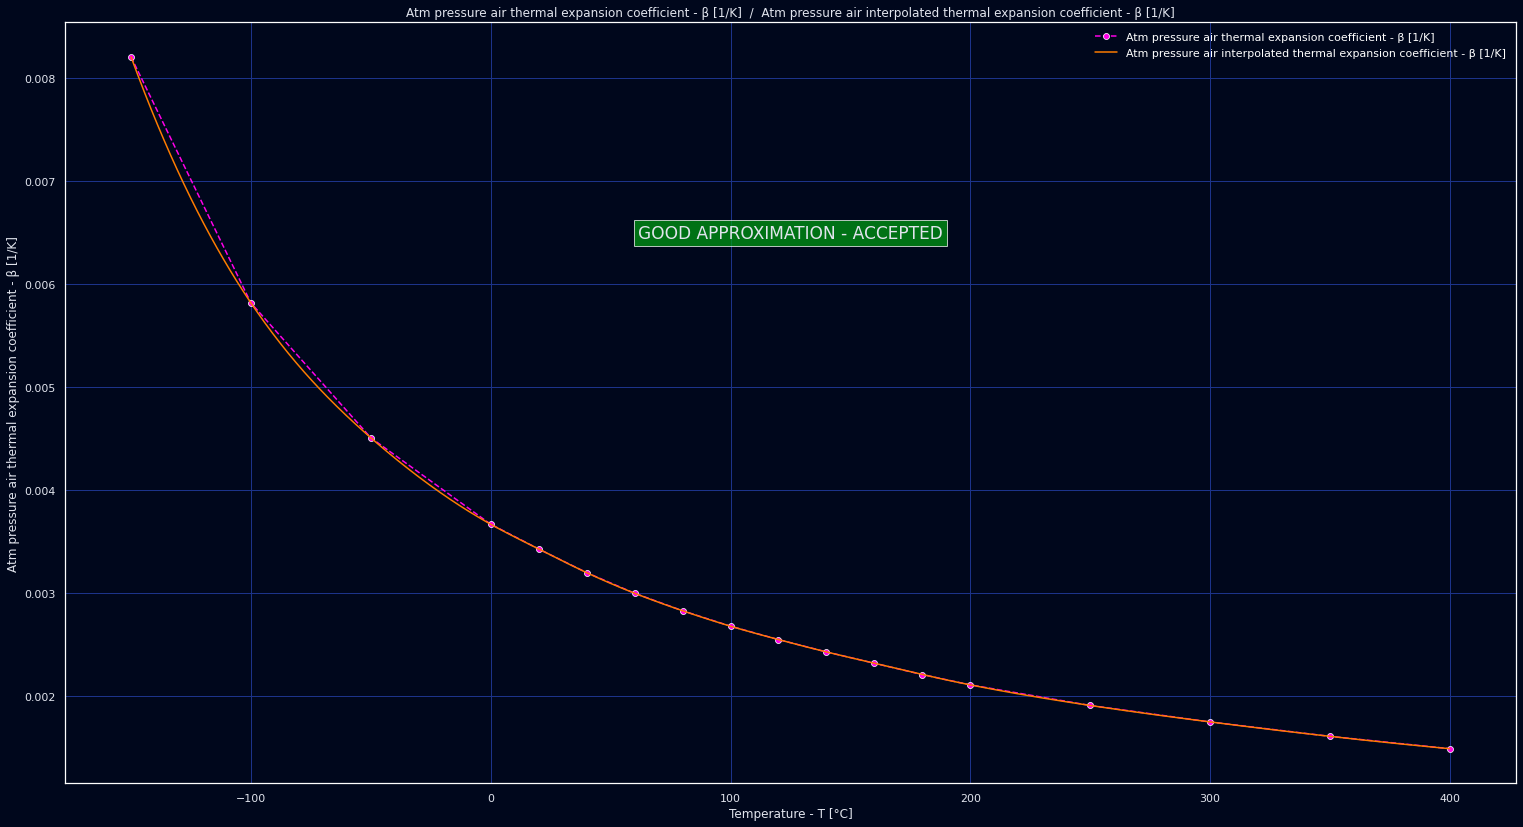

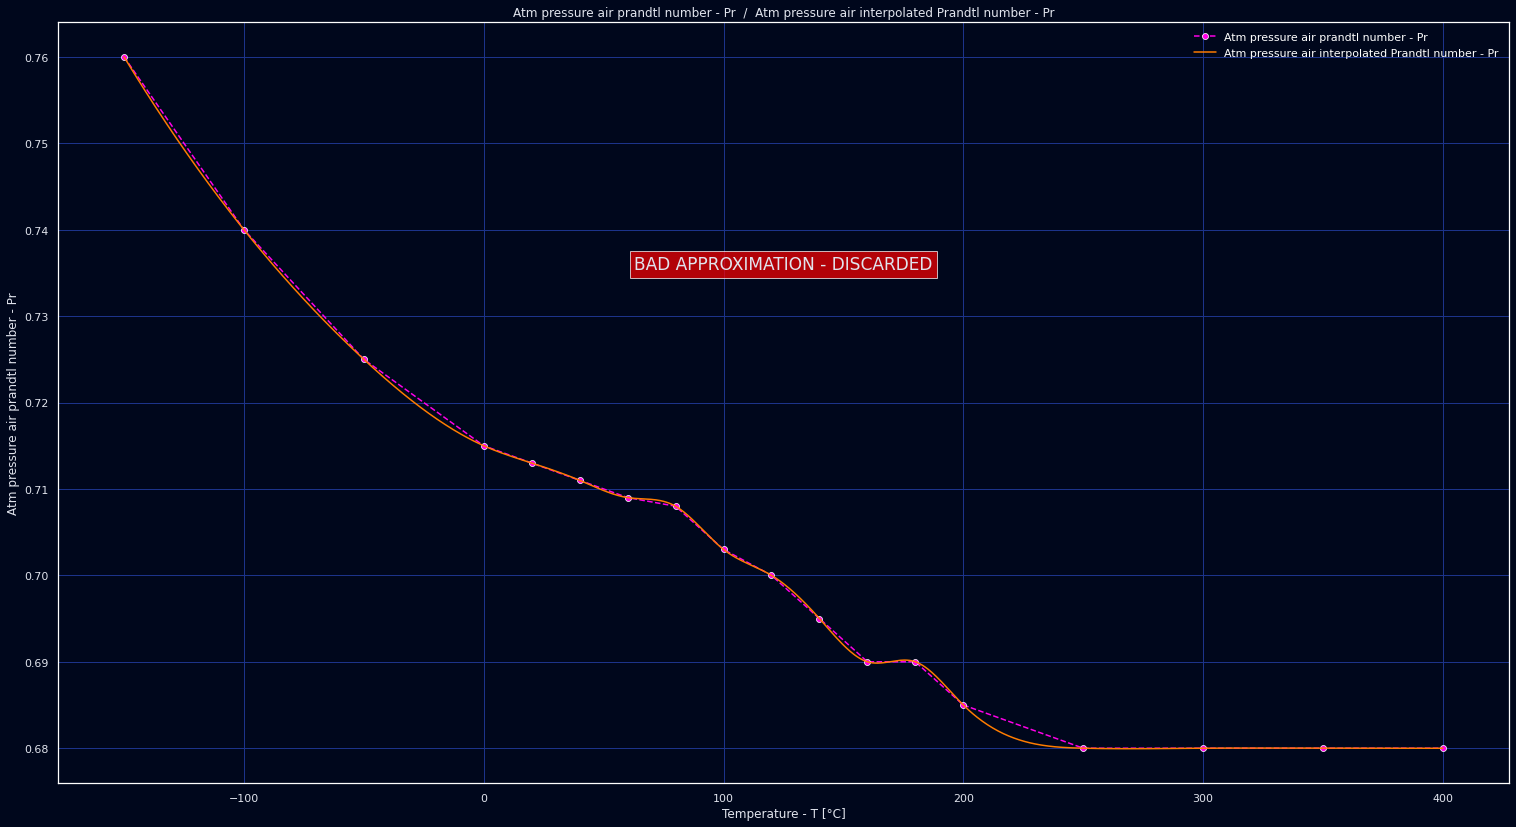

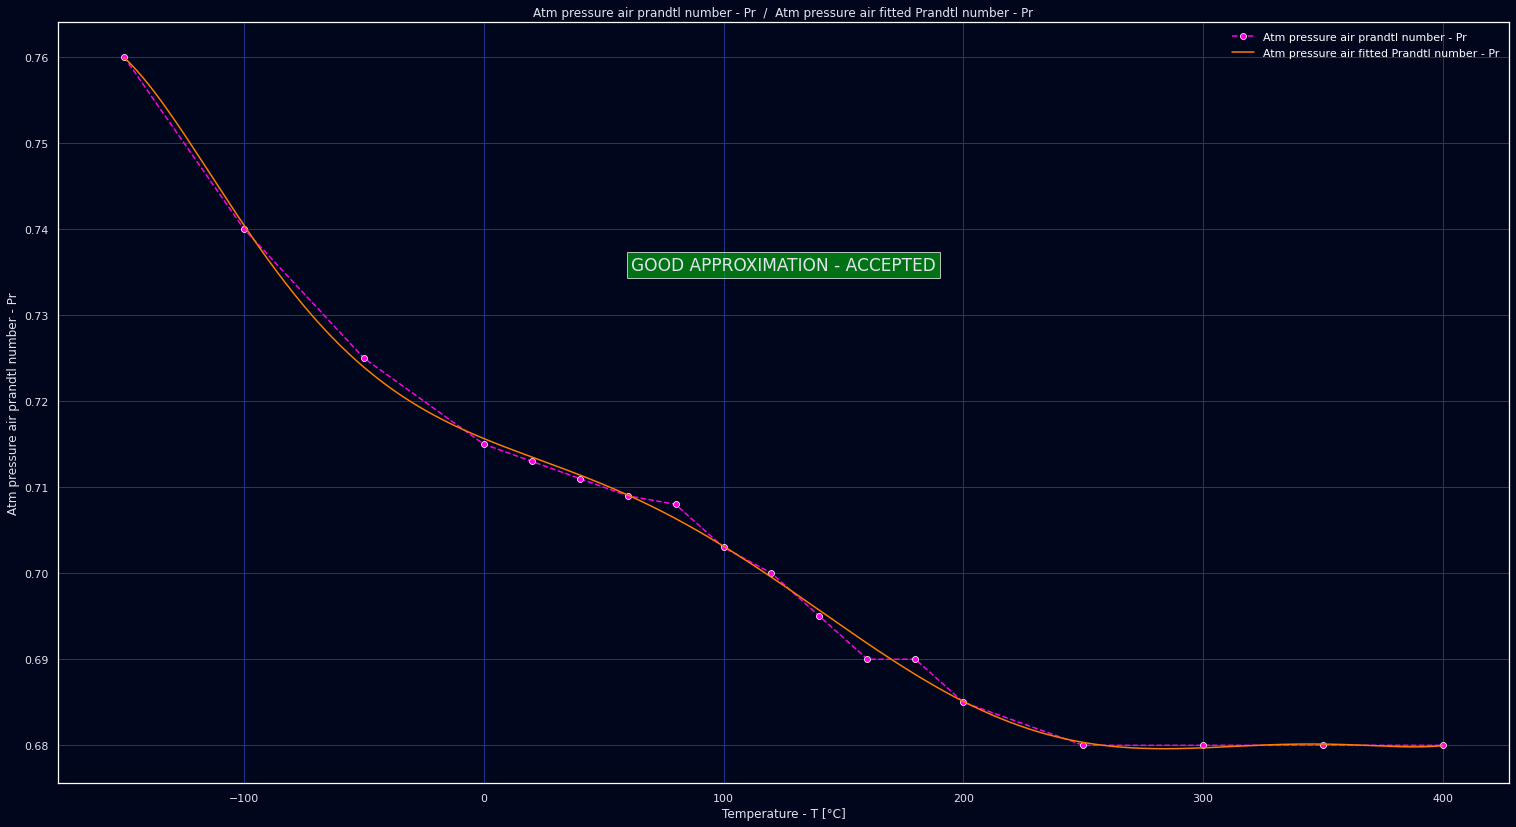

<Figure size 1872x1008 with 0 Axes>

In [13]:
f_air_atmp_rho, f_air_atmp_cp, f_air_atmp_lambda, f_air_atmp_ni, f_air_atmp_beta, f_air_atmp_pr = tv.poly_approx_plot_air_atmp_thermophys_vars(air_atmp, thermophys_vars_plt_flg)   # Function call

### - Water's thermophysical variables polynomial approximation 

* Function call to apply water's thermophysical variables polynomial approximation and plotting vs temperature

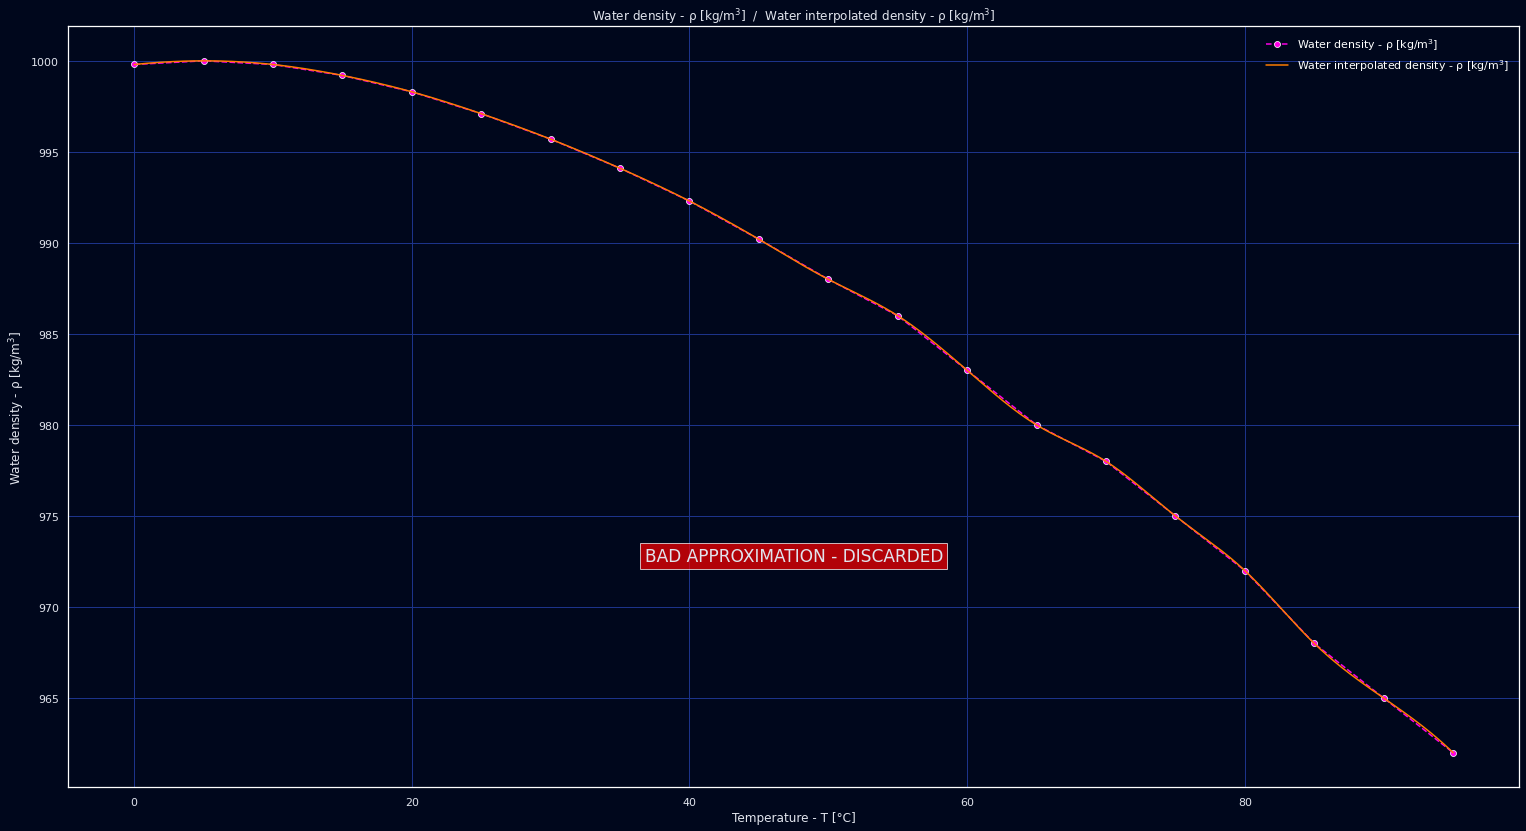

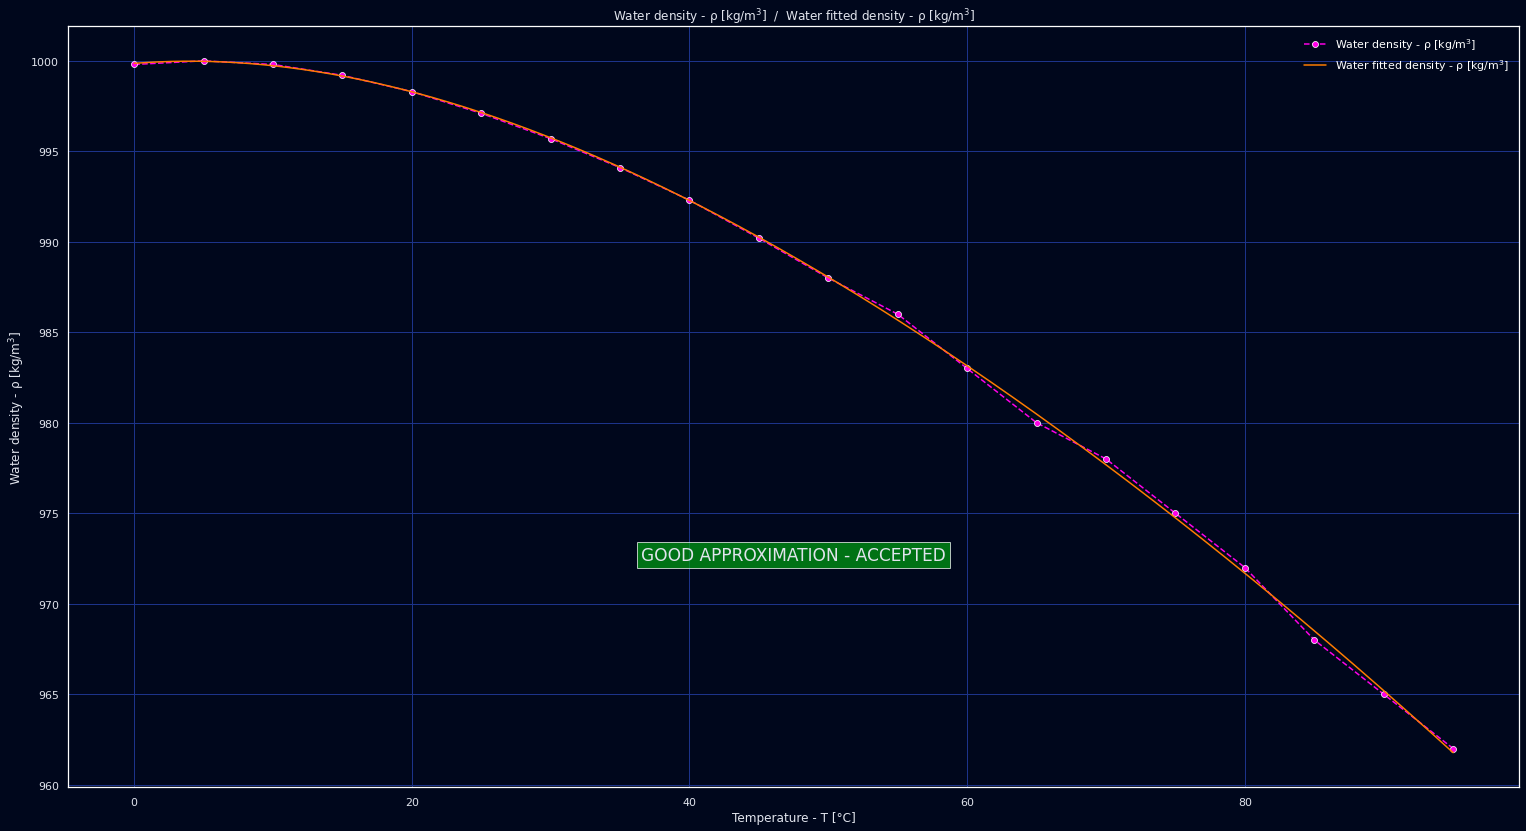

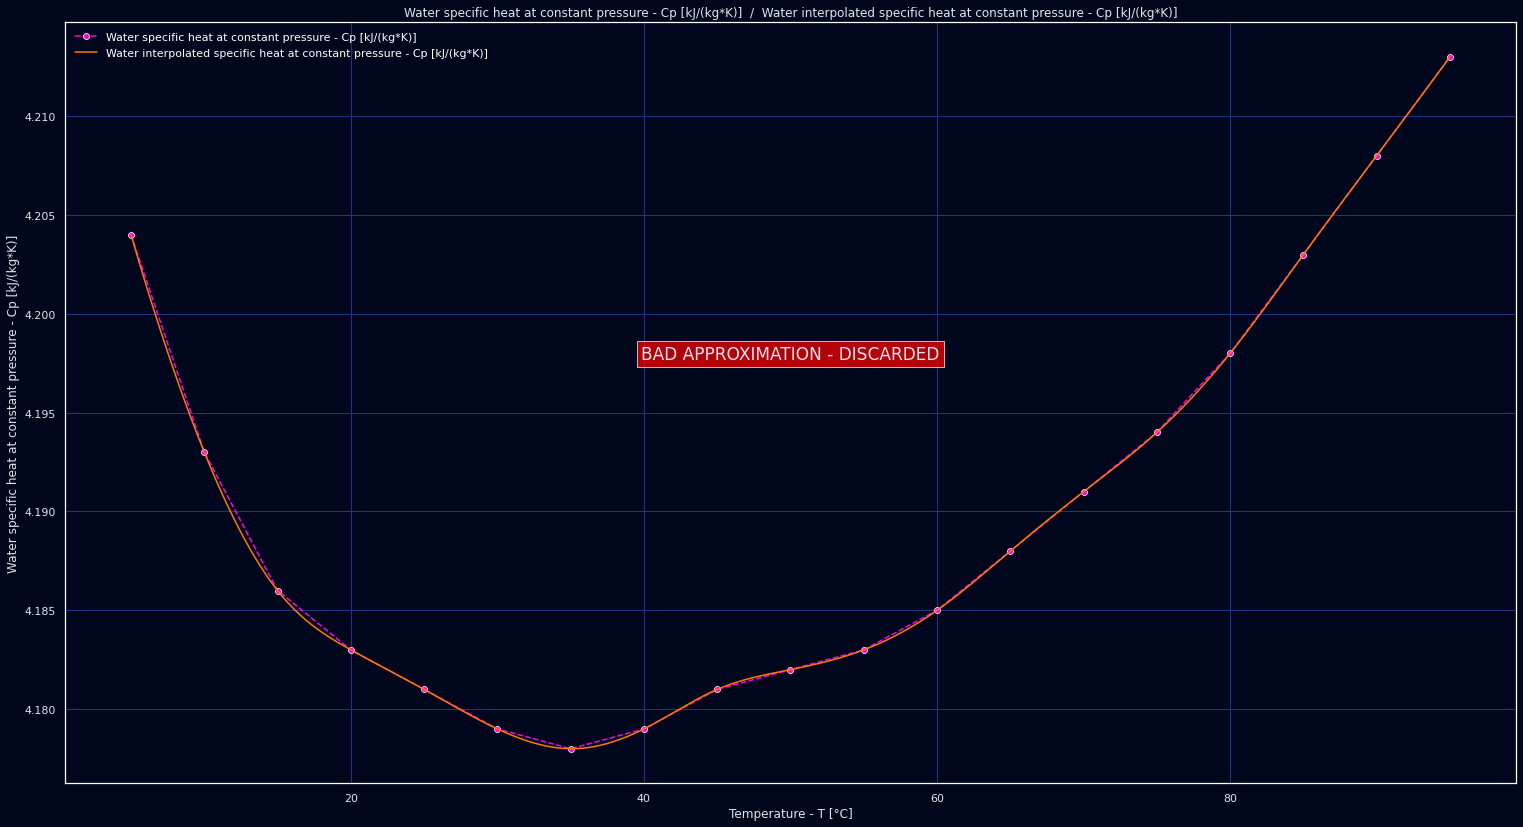

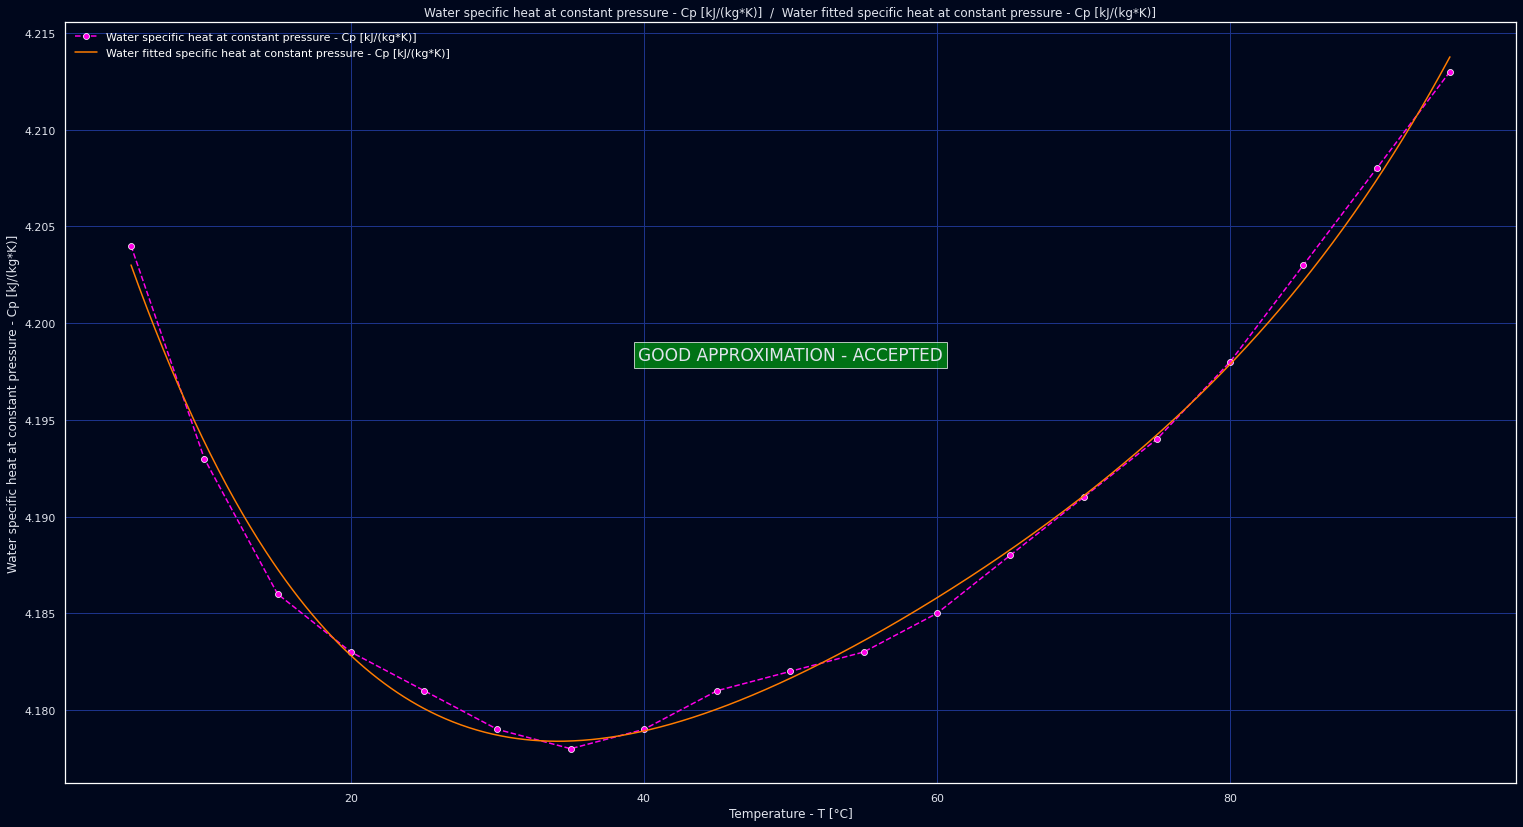

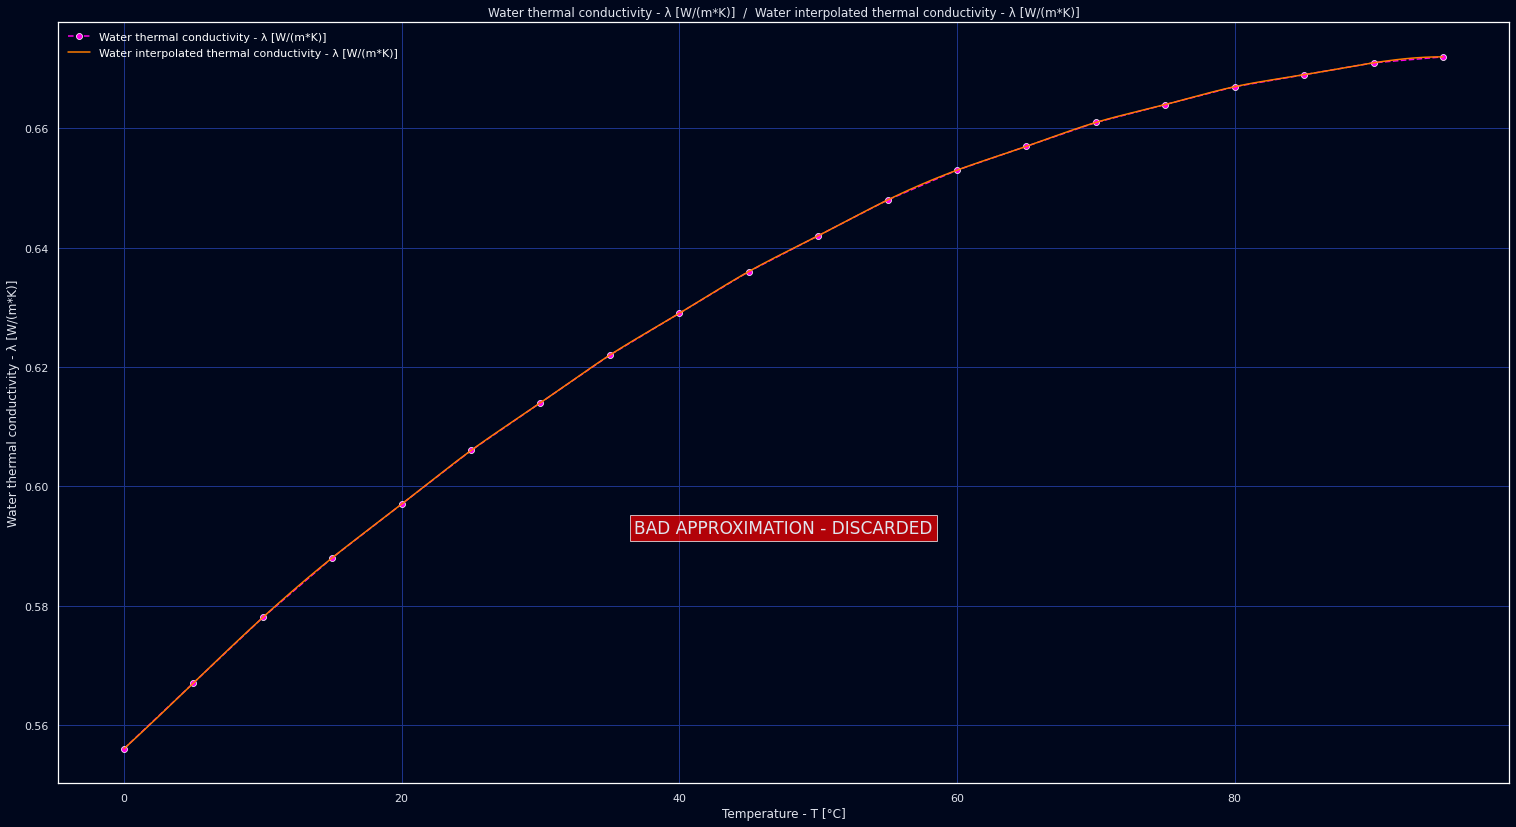

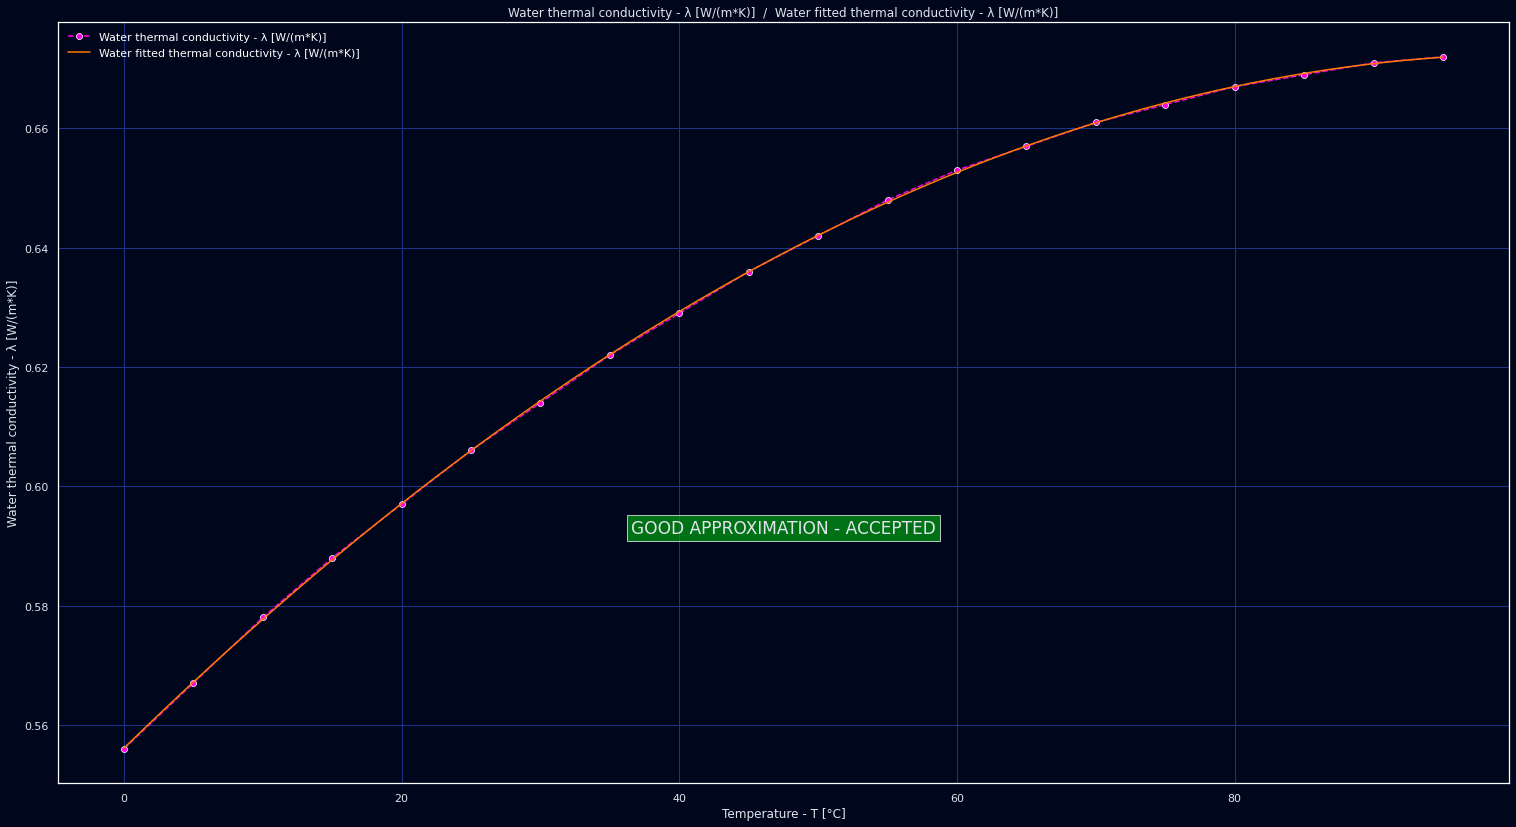

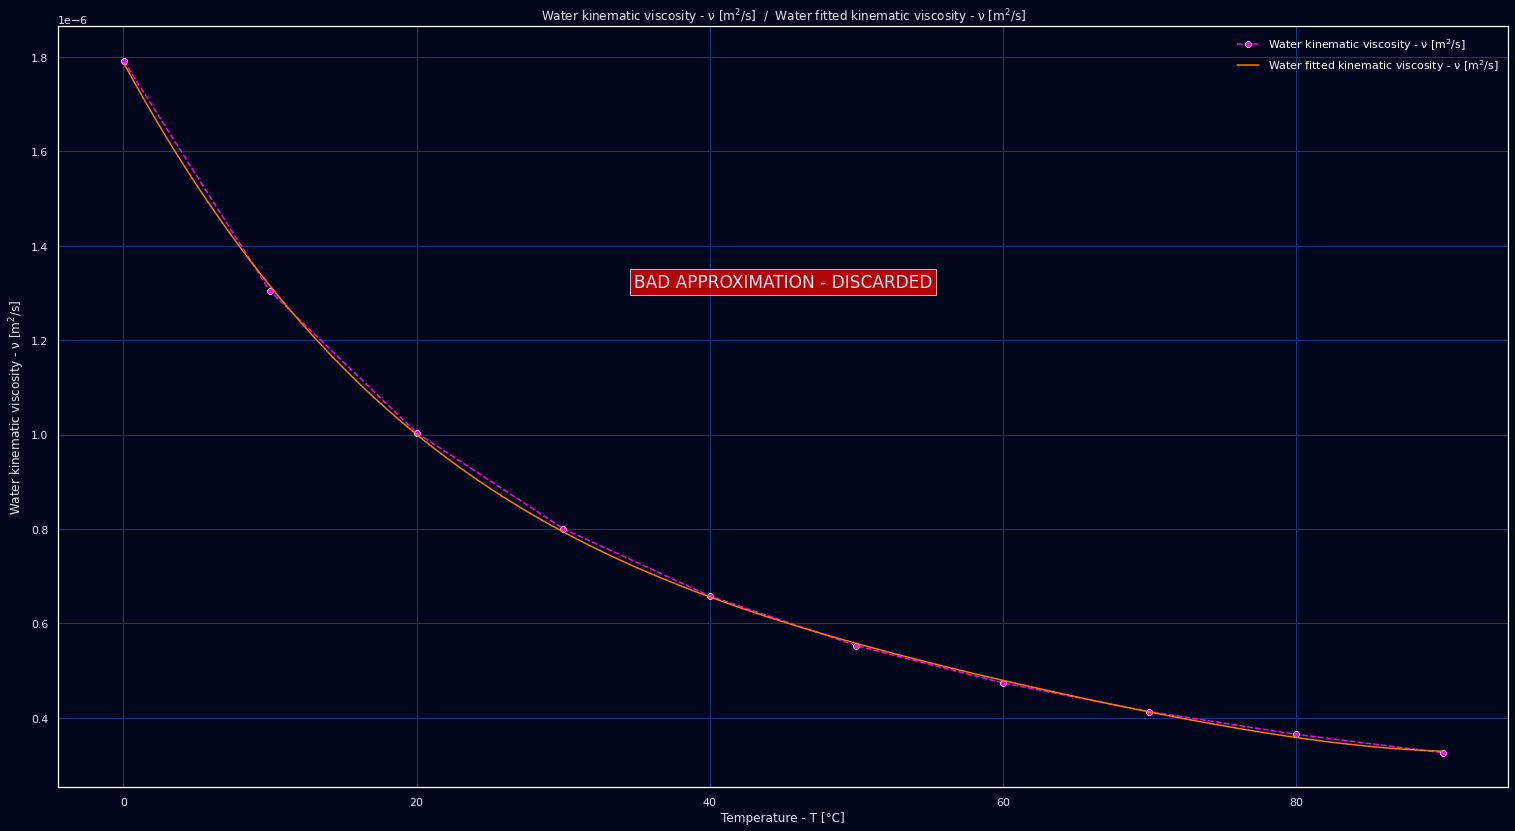

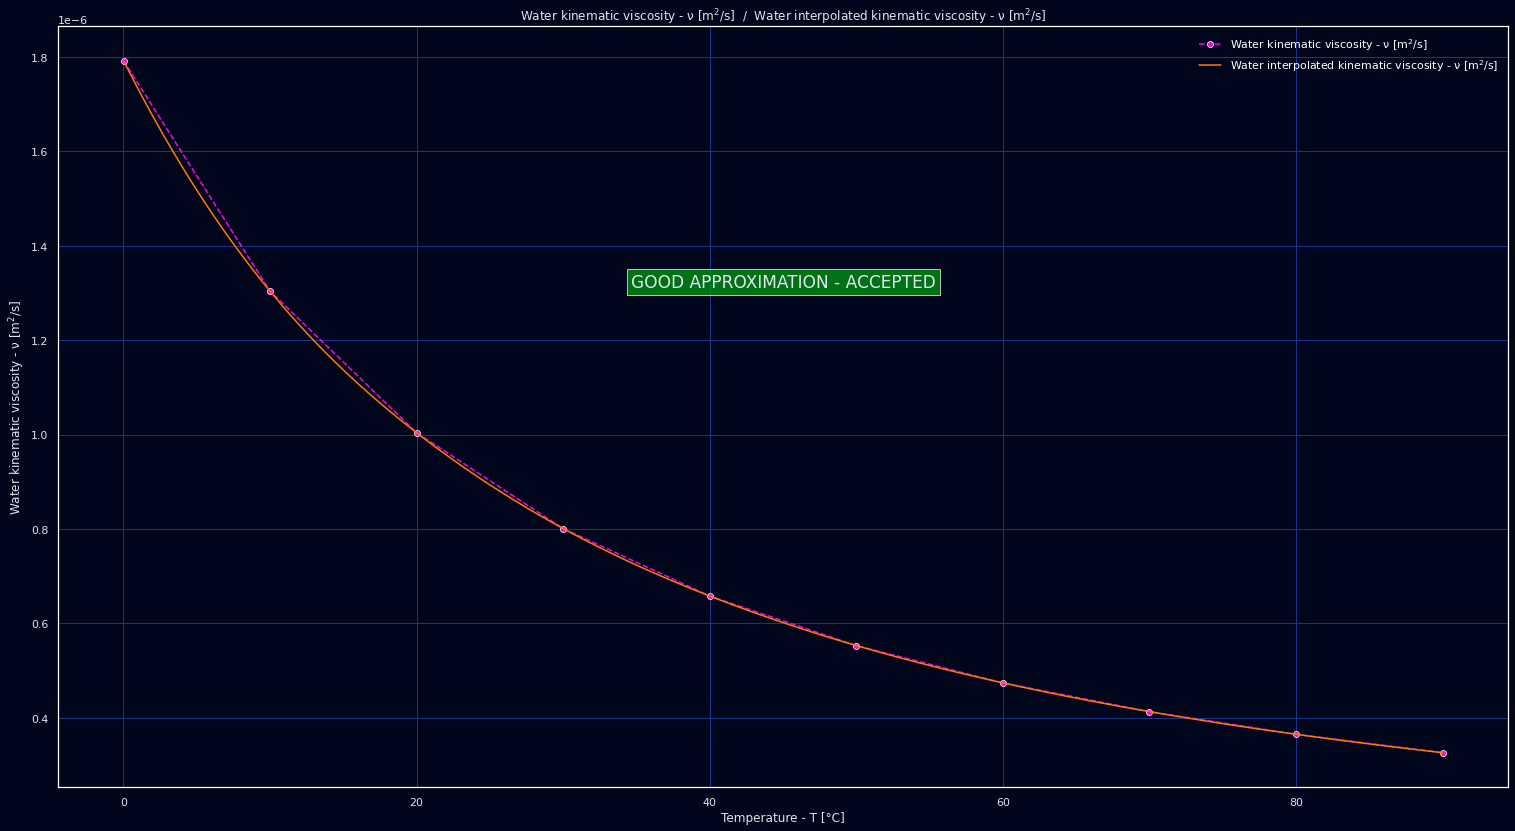

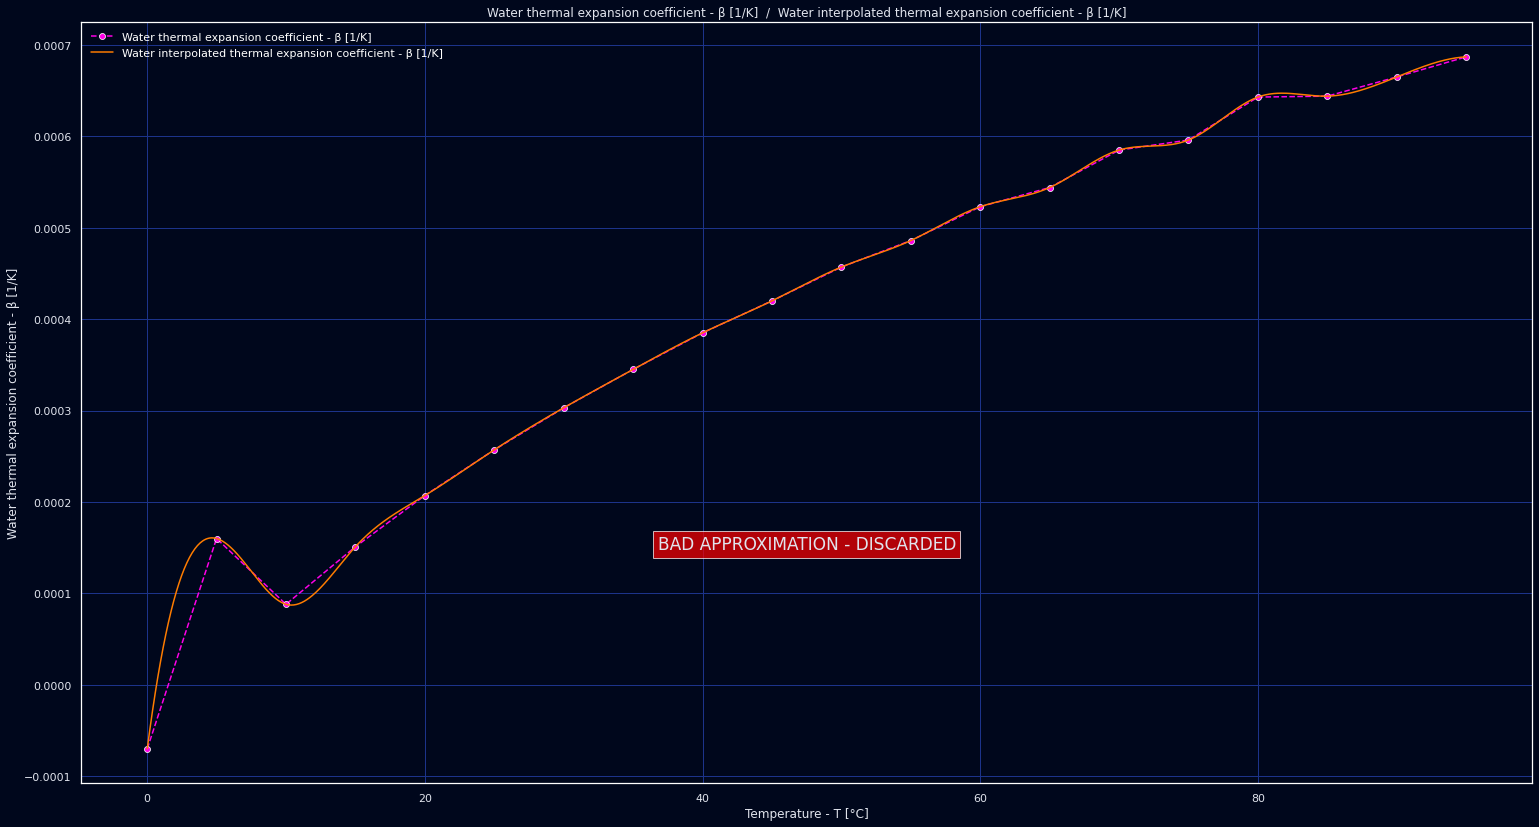

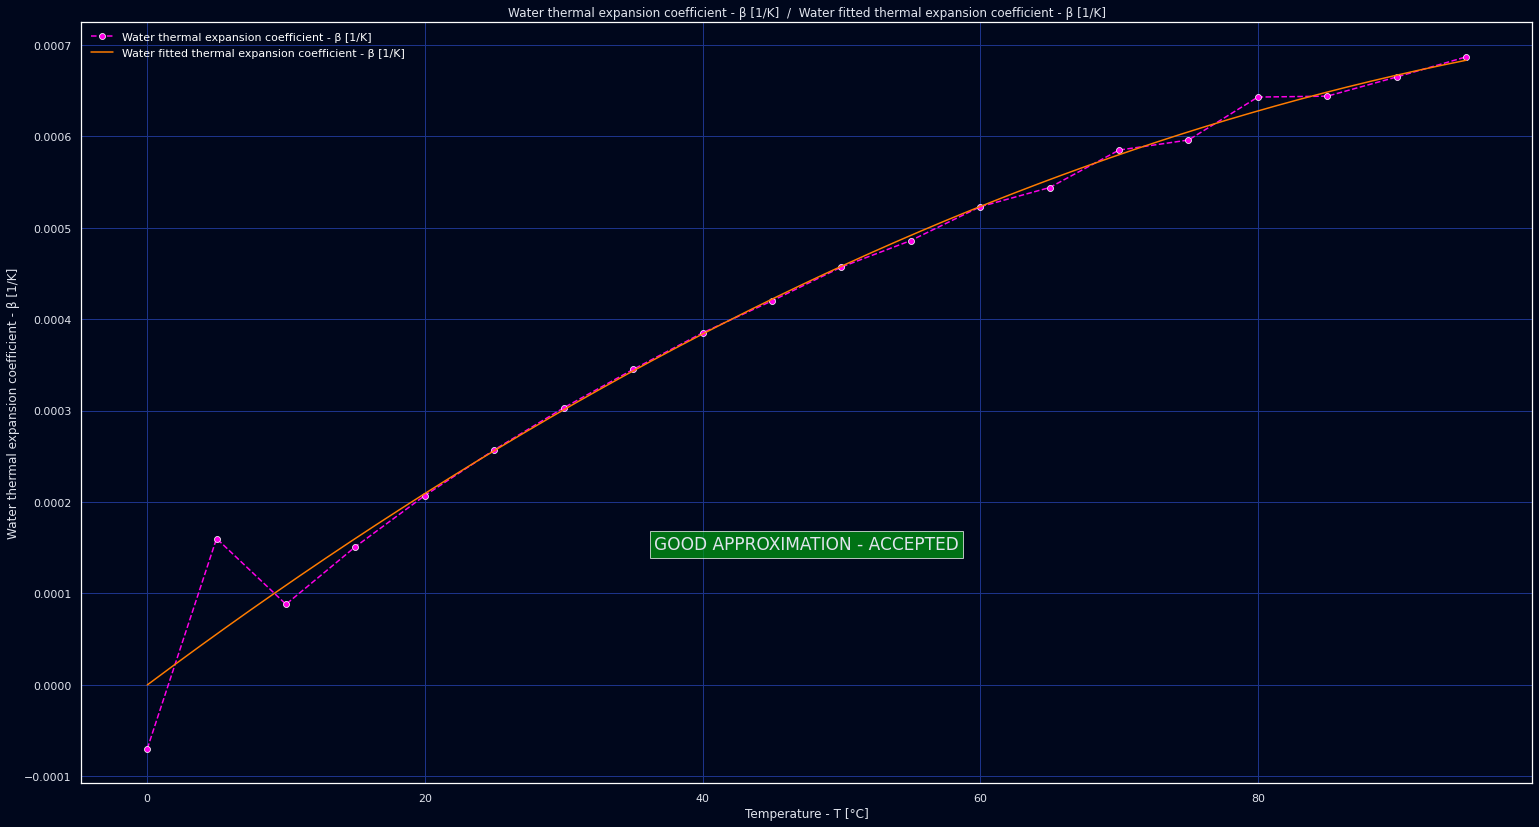

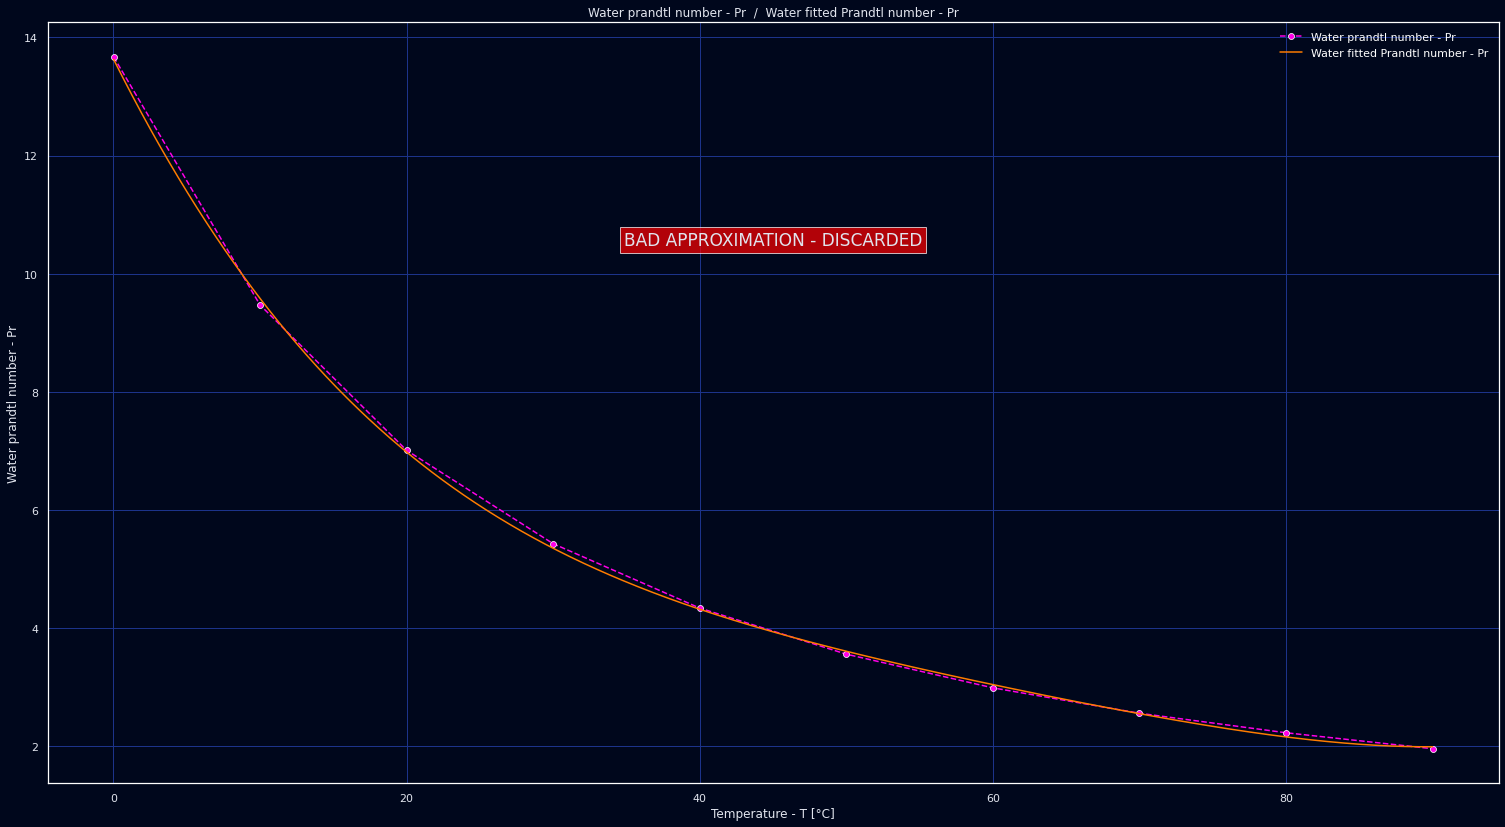

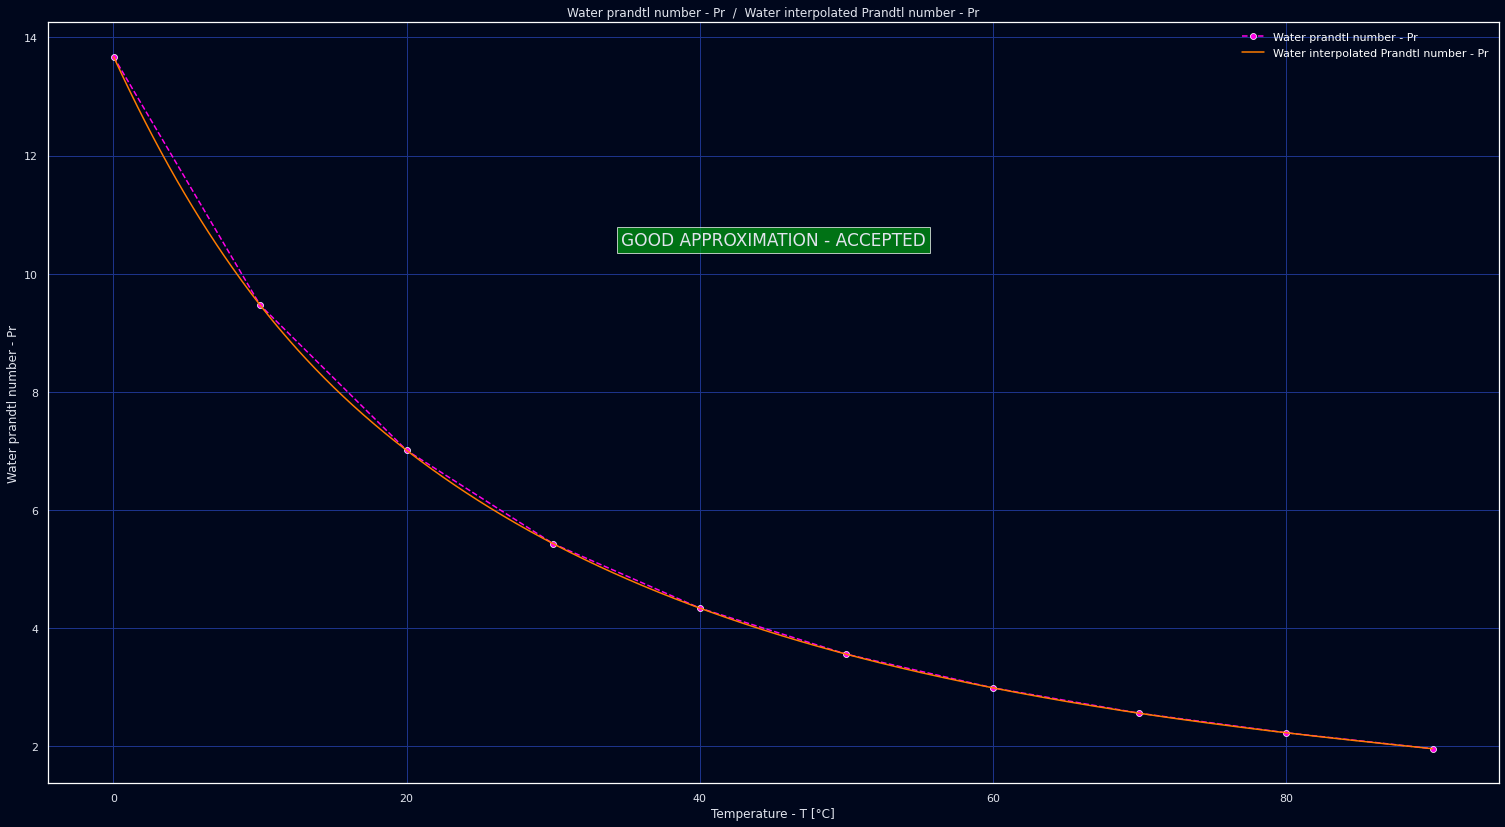

<Figure size 1872x1008 with 0 Axes>

In [14]:
f_water_rho, f_water_cp, f_water_lambda, f_water_ni, f_water_beta, f_water_pr = tv.poly_approx_plot_water_thermophys_vars(water, thermophys_vars_plt_flg)   # Function call

### - AISI-316-stainless-steel's thermophysical variables polynomial approximation

* Function call to apply AISI-316-stainless-steel's thermophysical variables polynomial approximation and plotting vs temperature

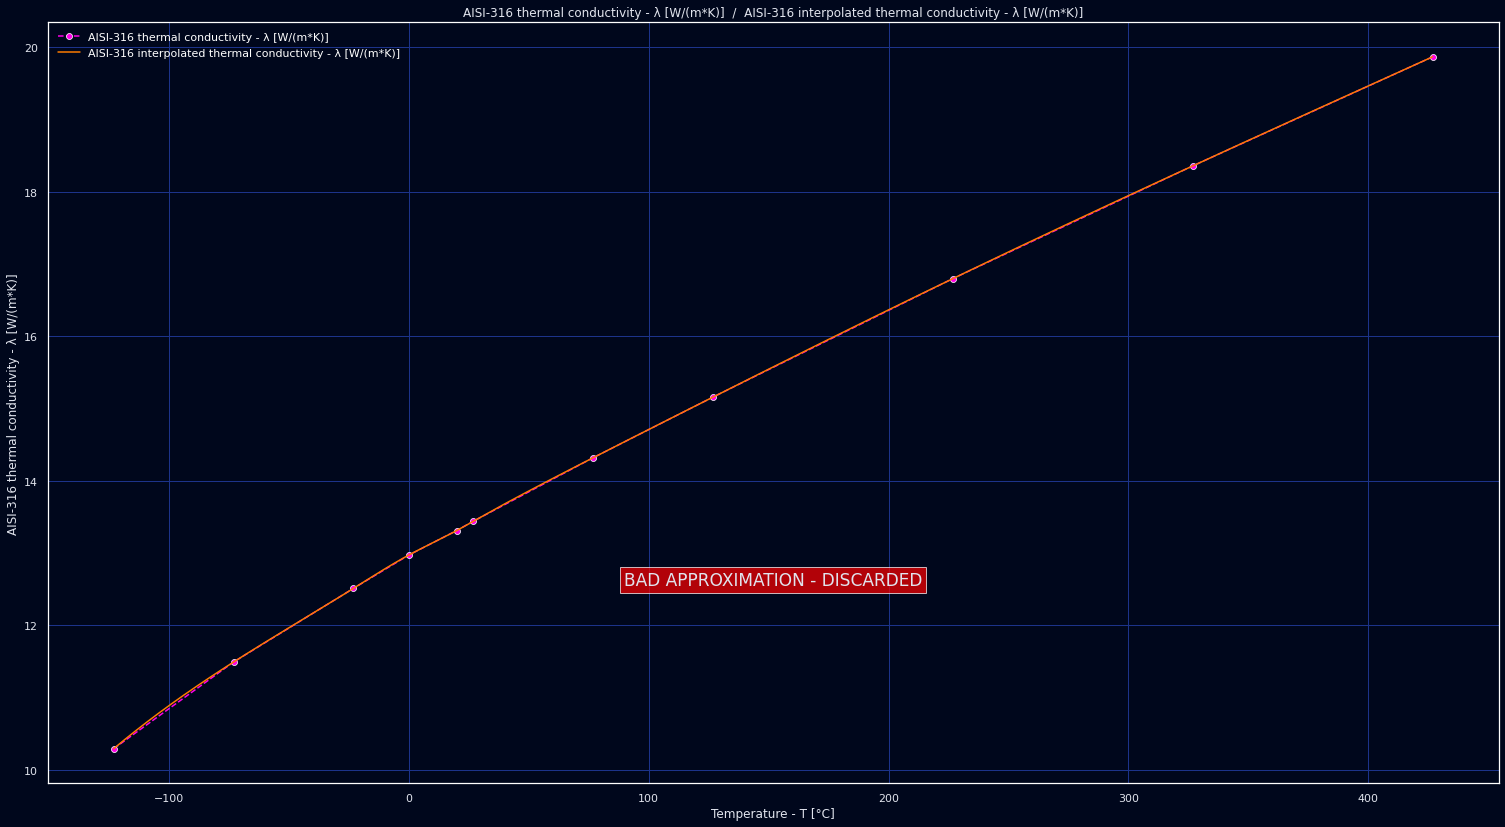

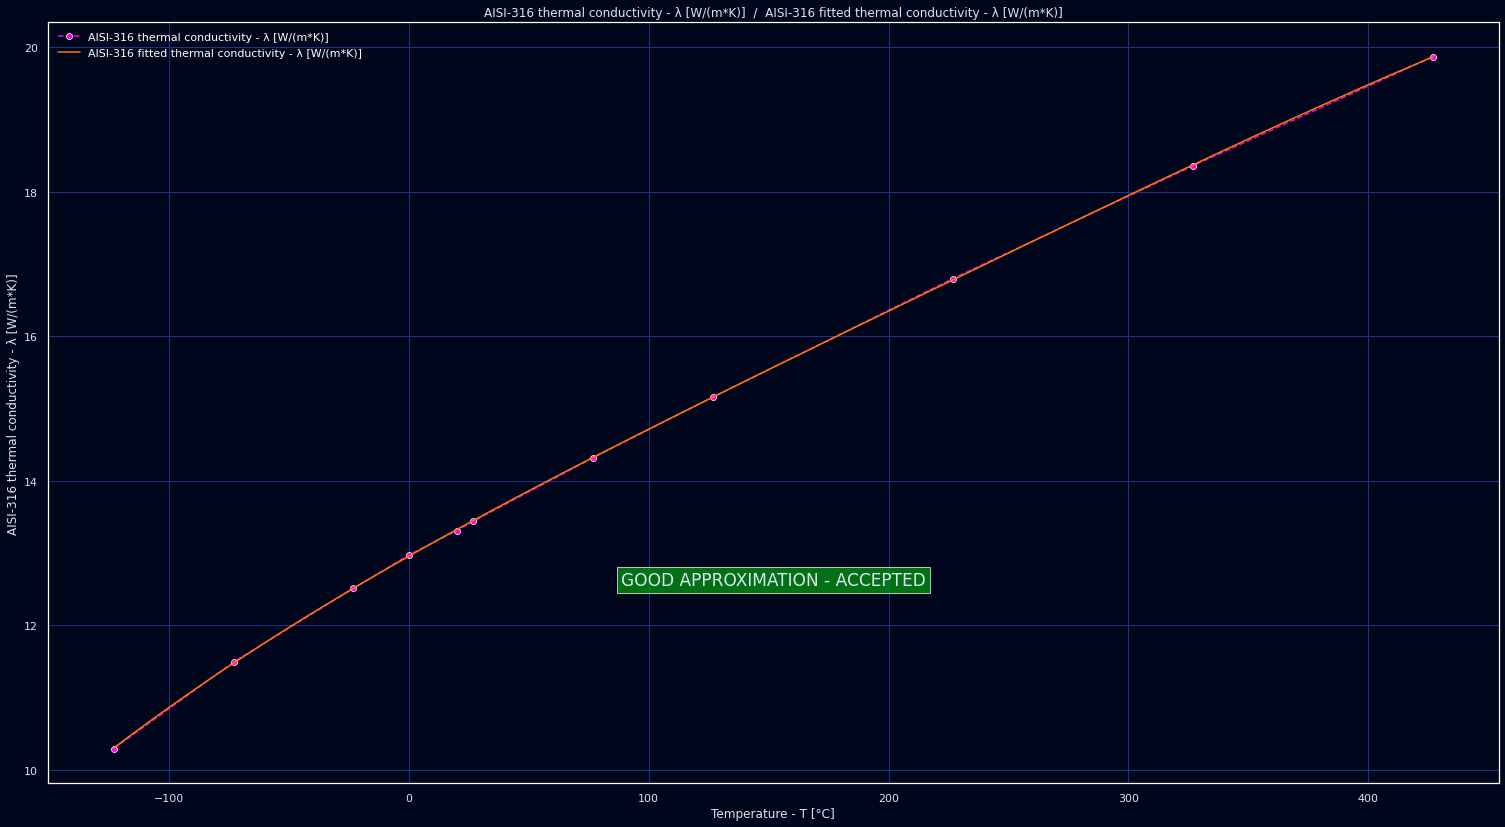

<Figure size 1872x1008 with 0 Axes>

In [15]:
f_aisi_316_lambda = tv.poly_approx_plot_aisi_316_thermophys_vars(aisi_316, thermophys_vars_plt_flg)   # Function call

### - Thermophysical variables polynomial approximation of borosilicate (pyrex) glass

* Function call to apply thermophysical variables polynomial approximation and plotting vs temperature of borosilicate (pyrex) glass

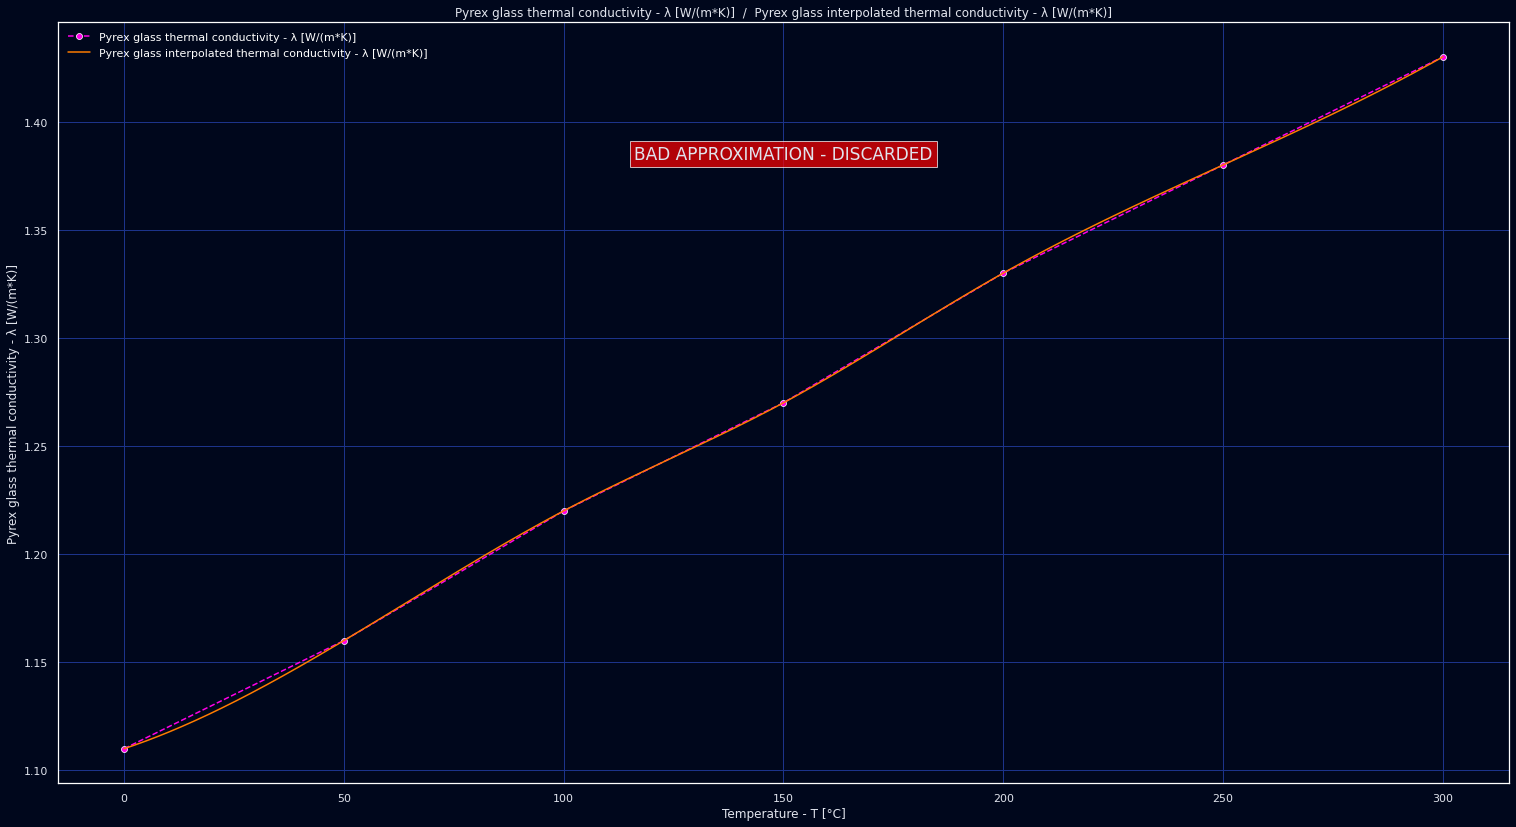

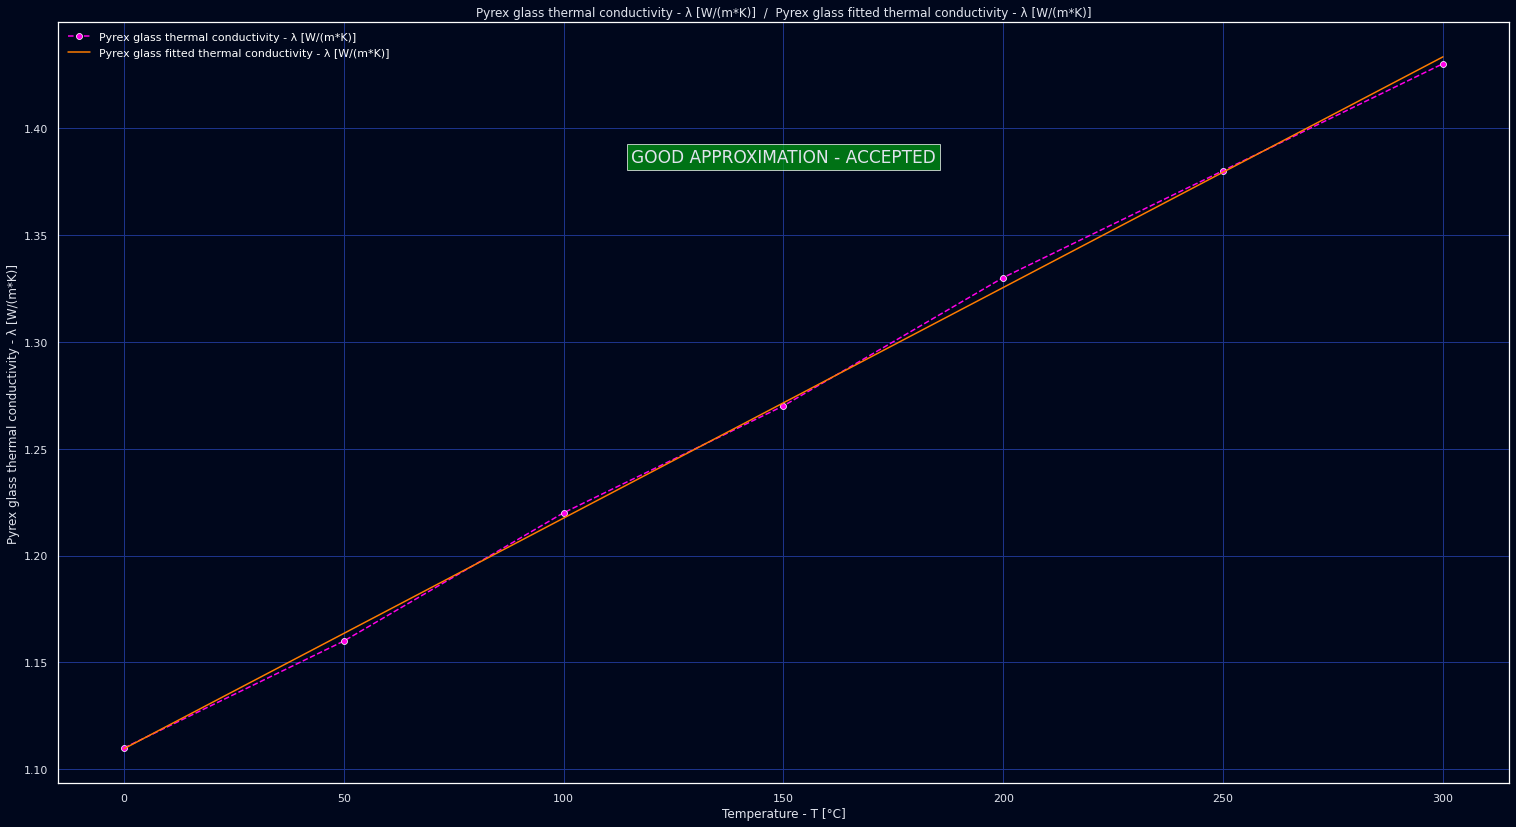

<Figure size 1872x1008 with 0 Axes>

In [16]:
f_pyrex_glass_lambda = tv.poly_approx_plot_pyrex_glass_thermophys_vars(pyrex_glass, thermophys_vars_plt_flg)    # Function call

## Engineering calcs

### - Heat-exchanger object initialization

* Initialize heat-exchanger with defined/calculated geometrical properties, saving heat-exchanger info in output file

In [17]:
he = ec.He()                          # Heat-exchanger object instance creation
he.print_info_save_out(he_dbg_flg)    # Print and save heat-exchanger info (if debug flag is enabled) by callin' the print-info method of the class


--> Heat-exchanger effective length: 0.68 [m]
--> Heat-exchanger glass pipe internal-diameter: 0.05 [m]
--> Heat-exchanger glass pipe internal-basal surface: 0.001963495408493621 [m^2]
--> Heat-exchanger glass pipe internal-lateral surface: 0.10681415022205297 [m^2]
--> Supposed heat-exchanger glass pipe thickness: 0.001 [m]
--> Supposed heat-exchanger glass pipe external-diameter: 0.052 [m]
--> Supposed heat-exchanger glass pipe external-lateral surface: 0.11108671623093509 [m^2]
--> Number of heat-exchanger diaphragms in glass pipe: 13
--> Heat-exchanger glass pipe diaphragms pace: 0.05 [m]
--> Heat-exchanger steel pipes internal-diameter: 0.008 [m]
--> Heat-exchanger steel pipes external-diameter: 0.01 [m]
--> Number of heat-exchanger steel pipes: 5
--> Heat-exchanger steel pipes pace: 0.015 [m]
--> Heat-exchanger steel pipes thickness: 0.001 [m]
--> Heat-exchanger interspace between steel pipes: 0.005 [m]
--> Heat-exchanger steel pipes internal-basal surface: 5.0265482457436686e-0

### - Experimental data conversions and pre-calcs operations

* Volume flow rates [l/h] conversion into [m^3/s] and mass flow rates [kg/s] using fluids density value at inlet fluid temperature

In [18]:
for meas in measures:                                                                                     # Measures scrollin' cycle
  meas.cold_fl_vol_flow_rate, meas.f1 = ec.vol_flow_rate_mass_flow_rate(meas.f1, f_water_rho(meas.t1))    # Measure cold fluid vol flow rate [l/h] conv into mass flow rate [kg/s]
  meas.hot_fl_vol_flow_rate, meas.f2 = ec.vol_flow_rate_mass_flow_rate(meas.f2, f_water_rho(meas.t2))     # Measure hot fluid vol flow rate [l/h] conv into mass flow rate [kg/s]

* Average fluid-temperatures calculation

In [19]:
for meas in measures:                                 # Measures scrollin' cycle
  meas.avg_cold_fl_temp = ec.avg(meas.t1, meas.t3)    # Measure avg cold fluid temp calc
  meas.avg_hot_fl_temp = ec.avg(meas.t2, meas.t4)     # Measure avg hot fluid temp calc

* Cold and hot fluids delta temperatures calculation

In [20]:
for meas in measures:                         # Measures scrollin' cycle
  meas.cold_fl_delta_temp = meas.t3-meas.t1   # Measure cold fluid delta-temp calc
  meas.hot_fl_delta_temp = meas.t4-meas.t2    # Measure hot fluid delta-temp calc

### - Thermal power exchanged and lost

* Thermal power exchanged by fluids [kW], thermal power losses [kW] and average thermal power [kW] calculated using Cp at average fluid temperatures

In [21]:
for meas in measures:                                                                                           # Measures scrollin' cycle
  meas.cold_fl_tr_heat = ec.therm_pow_kw(meas.f1, f_water_cp(meas.avg_cold_fl_temp), meas.cold_fl_delta_temp)   # Measure cold fluid transferred heat [kW]
  meas.hot_fl_tr_heat = ec.therm_pow_kw(meas.f2, f_water_cp(meas.avg_hot_fl_temp), meas.hot_fl_delta_temp)      # Measure hot fluid transferred heat [kW]
  meas.heat_losses = meas.hot_fl_tr_heat+meas.cold_fl_tr_heat                                                   # Measure heat losses [kW]
  meas.avg_tr_heat = ec.avg(abs(meas.cold_fl_tr_heat), abs(meas.hot_fl_tr_heat))                                # Measure average value of transferred heat [kW]

### - Global heat transfer coefficients (global HTCs) (approximative, imperfect co/countercurrent fluid flow due to diaphragms in heat-exchanger glass pipe)

* Approximative log-mean temperature difference (LMTDs) calculations

In [22]:
for meas in measures:                                     # Measures scrollin' cycle
  meas.lmtd = ec.lmtd(meas.t2-meas.t1, meas.t4-meas.t3)   # Measure approximative log-mean temperature difference (LMTD)

* Approximative global heat transfer coefficients (internal/external global HTCs) calculation using:  Q=U*A*Delta(T)ml  -->  U=Q/(a*Delta(T)ml)

In [23]:
for meas in measures:                                                                                       # Measures scrollin' cycle
  meas.int_approx_glob_htc = ec.glob_htc_kw_m2_k(meas.avg_tr_heat, he.steel_pipes_ils_m2, meas.lmtd)        # Measure approximative internal global heat transfer coefficient (global HTC) [kW/(m^2*K)]
  meas.ext_approx_glob_htc = ec.glob_htc_kw_m2_k(meas.avg_tr_heat, he.steel_pipes_els_m2, meas.lmtd)        # Measure approximative external global heat transfer coefficient (global HTC) [kW/(m^2*K)]

### - Effectiveness-NTU method (approximative, imperfect co/countercurrent fluid flow due to diaphragms in heat-exchanger glass pipe)

* Approximative C-point-min=min(mass-flow-rate\*Cp) and C-point-max=max(mass-flow-rate\*Cp) calcs

In [24]:
for meas in measures:                                                                                                                     # Measures scrollin' cycle
  meas.cpt_min, meas.cpt_max = ec.cptmin_cptmax(meas.f1, f_water_cp(meas.avg_cold_fl_temp), meas.f2, f_water_cp(meas.avg_hot_fl_temp))    # Calculate measure approximative C-point-min and C-point-max

* Approximative number of transfer units (NTUs) calcs

In [25]:
for meas in measures:                                                                 # Measures scrollin' cycle
  meas.ntu = ec.ntu(meas.ext_approx_glob_htc, he.steel_pipes_els_m2, meas.cpt_min)    # Calculate measure approximative number of transfer units (NTU) using external global HTC and external steel pipes surface

* Approximative effectiveness calcs

In [26]:
for meas in measures:                                                               # Measures scrollin' cycle
  meas.epsilon = ec.effectiveness(meas.typ, meas.ntu, meas.cpt_min/meas.cpt_max)    # Calculate measure approximative effectiveness (epsilon)

### - Print measures and calcs results saving them in approx output file

* Print measures calculations results

In [27]:
ec.print_save_measures_calcs_res(measures, meas_calcs_dbg_flg, out.Output_typ.measures_approx_calcs)    # Function call to print and save measures calcs results


--> Cocurrent measure 1 calculations results:
- Cold fluid mass flow rate: 0.1498469840803731 [kg/s]
- Hot fluid mass flow rate: 0.15429849930385225 [kg/s]
- Cold fluid inlet temperature: 15.254444444444452 [°C]
- Hot fluid inlet temperature: 51.24088888888886 [°C]
- Cold fluid outlet temperature: 24.349777777777817 [°C]
- Hot fluid outlet temperature: 41.90299999999992 [°C]
- Cold fluid volume flow rate: 0.0001499783950617284 [m^3/s]
- Hot fluid volume flow rate: 0.00015625617283950618 [m^3/s]
- Average cold fluid temperature: 19.802111111111135 [°C]
- Average hot fluid temperature: 46.57194444444439 [°C]
- Cold fluid delta temperature: 9.095333333333365 [°C]
- Hot fluid delta temperature: -9.33788888888894 [°C]
- Cold fluid transferred heat (thermal power): 5.700996970190151 [kW]
- Hot fluid transferred heat (thermal power): -6.023372300191799 [kW]
- Heat losses (thermal power): -0.3223753300016474 [kW]
- Average value of transferred heat (thermal power): 5.8621846351909745 [kW]
- A

### - Overall heat transfer coefficients with adimensional numbers and thermal resistances

* Heat exchanger steel pipes surface temperature approximation (average) for steel thermal conductivity calc, define shell inlet/outlet sections fluid temperatures and calc steel pipes absolute conductive resistance [K/W]

In [28]:
for meas in measures:                                                                                                                                 # Measures scrollin' cycle
  meas.approx_surf_temp, meas.ext_in_sect_fl_temp, meas.ext_out_sect_fl_temp = ec.define_temp(meas)                                                   # Calculate approximated steel pipes surface temperature (avg) and define shell inlet/outlet fluid temp
  meas.steel_pipes_therm_cond = f_aisi_316_lambda(meas.approx_surf_temp)                                                                              # Measure steel pipes (AISI-316) thermal conductivity calc
  meas.int_pipes_cond_r = ec.abs_cond_res(he.steel_pipes_id_m, he.steel_pipes_ed_m, he.eff_len_m, he.steel_pipes_num, meas.steel_pipes_therm_cond)    # Measure absolute conductive resistace calc (for N steel pipes)

* Fluid thermal conductivity, dynamic viscosity, Prandtl, Reynolds, Nusselt adimensional numbers and heat-transfer coefficient (h) calc for fluid inside steel pipes with mass flow rate divided by the number of cylindrical steel pipes

In [29]:
for meas in measures:                                                                                                                                                                                   # Measures scrollin' cycle
  meas.int_therm_cond = f_water_lambda(meas.avg_hot_fl_temp)                                                                                                                                            # Measure internal fluid thermal conductivity at avg fluid temp calc
  meas.int_dyn_vis = ec.dyn_vis(f_water_ni, f_water_rho, meas.avg_hot_fl_temp)                                                                                                                          # Measure internal fluid dynamic viscosity at avg fluid temp calc
  if (not use_re_alt):                                                                                                                                                                                  # If flag to calculate Reynolds in alternative way ain't set
    meas.int_re = ec.re(ec.He_side.tube, meas.f2/he.steel_pipes_num, he.steel_pipes_id_m, meas.int_dyn_vis, None)                                                                                       # Measure internal fluid Reynolds number calc
  else:                                                                                                                                                                                                 # Else if flag to calculate Reynolds in alternative way is set
    meas.int_re = ec.re_aternative(meas.hot_fl_vol_flow_rate/he.steel_pipes_num, he.steel_pipes_ibs_m2, he.steel_pipes_id_m, f_water_ni(meas.avg_hot_fl_temp))                                          # Measure internal fluid Reynolds number calc (alternative way)
  meas.int_pr = f_water_pr(meas.avg_hot_fl_temp)                                                                                                                                                        # Measure internal fluid Prandtl number at avg fluid temp calc
  meas.int_nu = ec.nu(ec.He_side.tube, meas.int_re, meas.int_pr, meas.int_dyn_vis, ec.dyn_vis(f_water_ni, f_water_rho, meas.approx_surf_temp), he.steel_pipes_id_m, he.eff_len_m*he.steel_pipes_num)    # Measure internal fluid Nusselt number calc (Mu-s approx using steel pipes avg calc temp, not used in case of turbulent flow inside steel pipes: NOT USED - PREDISPOSITION ONLY)
  meas.int_h = ec.h_from_nu_w_m2_k(meas.int_nu, he.steel_pipes_id_m, meas.int_therm_cond)                                                                                                               # Measure internal fluid heat transfer coeff (h) calc

* Absolute convective resistances inside steel pipes calc [K/W] and steel pipes internal/external surface temperatures calculation

In [30]:
for meas in measures:                                                                                                                                                             # Measures scrollin' cycle
  meas.int_fl_conv_r = ec.abs_conv_res(meas.int_h, he.steel_pipes_ils_m2)                                                                                                         # Measure internal fluid convective resistace calculation
  meas.int_pipe_int_surf_temp, meas.int_pipe_ext_surf_temp = ec.calc_pipe_int_ext_surf_temp(meas.avg_tr_heat, meas.avg_hot_fl_temp, meas.int_fl_conv_r, meas.int_pipes_cond_r)    # Measure steel pipes internal and external surface temperatures calc

* Fluid thermal conductivities, dynamic viscosities, Prandtl, Reynolds, Nusselt adimensional numbers, heat-transfer coefficients (h) inside inelt/outlet section and average heat-transfer coefficient (h) calc for fluid inside glass pipe

In [31]:
for meas in measures:                                                                                                                                                                                   # Measures scrollin' cycle
  meas.ext_in_sect_therm_cond = f_water_lambda(meas.ext_in_sect_fl_temp)                                                                                                                                # Measure external fluid thermal conductivity at inlet fluid temp calc
  meas.ext_out_sect_therm_cond = f_water_lambda(meas.ext_out_sect_fl_temp)                                                                                                                              # Measure external fluid thermal conductivity at outlet fluid temp calc
  meas.ext_in_sect_dyn_vis = ec.dyn_vis(f_water_ni, f_water_rho, meas.ext_in_sect_fl_temp)                                                                                                              # Measure external fluid dynamic viscosity at inlet fluid temp calc
  meas.ext_out_sect_dyn_vis = ec.dyn_vis(f_water_ni, f_water_rho, meas.ext_out_sect_fl_temp)                                                                                                            # Measure external fluid dynamic viscosity at otlet fluid temp calc
  if (not use_re_alt):                                                                                                                                                                                  # If flag to calculate Reynolds in alternative way ain't set
    meas.ext_in_sect_re = ec.re(ec.He_side.shell, meas.f1, None, meas.ext_in_sect_dyn_vis, he)                                                                                                          # Measure external fluid Reynolds number calc inside inlet section
    meas.ext_out_sect_re = ec.re(ec.He_side.shell, meas.f1, None, meas.ext_out_sect_dyn_vis, he)                                                                                                        # Measure external fluid Reynolds number calc inside otlet section
  else:                                                                                                                                                                                                 # Else if flag to calculate Reynolds in alternative way is set
    meas.ext_in_sect_re = ec.re_aternative(meas.cold_fl_vol_flow_rate, he.glass_pipe_ibs_m2, ec.shell_eq_hyd_diam_m(he), f_water_ni(meas.ext_in_sect_fl_temp))                                          # Measure external fluid Reynolds number calc inside inlet section (alternative way)
    meas.ext_out_sect_re = ec.re_aternative(meas.cold_fl_vol_flow_rate, he.glass_pipe_ibs_m2, ec.shell_eq_hyd_diam_m(he), f_water_ni(meas.ext_out_sect_fl_temp))                                        # Measure external fluid Reynolds number calc inside outlet section (alternative way)
  meas.ext_in_sect_pr = f_water_pr(meas.ext_in_sect_fl_temp)                                                                                                                                            # Measure external fluid Prandtl number at inlet fluid temp calc
  meas.ext_out_sect_pr = f_water_pr(meas.ext_out_sect_fl_temp)                                                                                                                                          # Measure external fluid Prandtl number at outlet fluid temp calc
  meas.ext_in_sect_nu = ec.nu(ec.He_side.shell, meas.ext_in_sect_re, meas.ext_in_sect_pr, meas.ext_in_sect_dyn_vis, ec.dyn_vis(f_water_ni, f_water_rho, meas.int_pipe_ext_surf_temp), None, None)       # Measure external fluid Nusselt number calc inside inlet section
  meas.ext_out_sect_nu = ec.nu(ec.He_side.shell, meas.ext_out_sect_re, meas.ext_out_sect_pr, meas.ext_out_sect_dyn_vis, ec.dyn_vis(f_water_ni, f_water_rho, meas.int_pipe_ext_surf_temp), None, None)   # Measure external fluid Nusselt number calc inside otlet section
  meas.ext_in_sect_h = ec.h_from_nu_w_m2_k(meas.ext_in_sect_nu, ec.shell_eq_hyd_diam_m(he), meas.ext_in_sect_therm_cond)                                                                                # Measure external fluid heat transfer coeff (h) calc inside inlet section
  meas.ext_out_sect_h = ec.h_from_nu_w_m2_k(meas.ext_out_sect_nu, ec.shell_eq_hyd_diam_m(he), meas.ext_out_sect_therm_cond)                                                                             # Measure external fluid heat transfer coeff (h) calc inside otlet section
  meas.ext_avg_h = ec.avg(meas.ext_in_sect_h, meas.ext_out_sect_h)                                                                                                                                      # Measure average external fluid heat transfer coeff (h) calc

* Calculate external fluid convective resistance on steel pipes, total thermal resistances and internal/external overall heat transfer coefficients

In [32]:
for meas in measures:                                                                                                               # Measures scrollin' cycle
  meas.ext_fl_conv_r = ec.abs_conv_res(meas.ext_avg_h, he.steel_pipes_els_m2)                                                       # Measure external fluid convective resistace calc
  meas.tot_therm_r = meas.int_fl_conv_r+meas.int_pipes_cond_r+meas.ext_fl_conv_r                                                    # Measure total thermal resistance calculation
  meas.int_ova_htc = ec.overall_htc_kw_m2_k(he.steel_pipes_ils_m2, meas.int_fl_conv_r, meas.int_pipes_cond_r, meas.ext_fl_conv_r)   # Measure internal overall heat transfer coefficient calc
  meas.ext_ova_htc = ec.overall_htc_kw_m2_k(he.steel_pipes_els_m2, meas.int_fl_conv_r, meas.int_pipes_cond_r, meas.ext_fl_conv_r)   # Measure external overall heat transfer coefficient calc
  meas.recalc_tr_heat = ec.therm_pow_kw_overall_htc(meas.ext_ova_htc, he.steel_pipes_els_m2, meas.lmtd)                             # Measure recalc fluid transferred heat (thermal power) using external overall heat transfer coeff

### - Percentage calculations

* Percentage of thermal power lost and percentage of thermal power calculation error using overall heat transfer coefficient from adimensional numbers instead of direct global heat transfer coefficient (vs avg value)

In [33]:
for meas in measures:                                                                               # Measures scrollin' cycle
  meas.perc_heat_losses = ec.perc(meas.heat_losses, meas.hot_fl_tr_heat, 1)                         # Measure heat losses percentage
  meas.perc_heat_calc_err = ec.perc(meas.recalc_tr_heat-meas.hot_fl_tr_heat, meas.avg_tr_heat, 1)   # Measure transferred heat calculation error in percentage

### Natural convection

* Glass thermal conductivity and shell thermal coductive/external-convective resistances calculation using Graschof, Rayleigh adimensional numbers and glass surface temperatres calculation 

In [34]:
for meas in measures:                                                                                                                                                                     # Measures scrollin' cycle
  meas.glass_pipe_avg_temp = ec.avg(meas.avg_cold_fl_temp, he.env_temp)                                                                                                                   # Measure glass pipe average temperature def to calc glass thermophysical variables values
  meas.glass_pipe_therm_cond = f_pyrex_glass_lambda(meas.glass_pipe_avg_temp)                                                                                                             # Measure glass pipe thermal conductivity calc
  meas.ext_pipe_cond_r = ec.abs_cond_res(he.glass_pipe_id_m, he.supp_glass_pipe_ed_m, he.eff_len_m, 1, meas.glass_pipe_therm_cond)                                                        # Measure absolute conductive resistace calc (for shell glass pipe)
  meas.ext_pipe_gr = ec.shell_gr(he.supp_glass_pipe_ed_m, f_air_atmp_beta(meas.glass_pipe_avg_temp), meas.ext_pipe_ext_surf_temp, he.env_temp, f_air_atmp_ni(meas.glass_pipe_avg_temp))   # Measure glass pipe Grashof number calc
  meas.ext_pipe_ra = ec.shell_ra(meas.ext_pipe_gr, f_air_atmp_pr(meas.glass_pipe_avg_temp))                                                                                               # Measure glass pipe Rayleigh number calc
  meas.ext_pipe_nu = ec.shell_nu_from_ra(meas.ext_pipe_ra)                                                                                                                                # Measure glass pipe Nusselt number calc
  meas.ext_pipe_h = ec.h_from_nu_w_m2_k(meas.ext_pipe_nu, he.supp_glass_pipe_ed_m, meas.glass_pipe_therm_cond)                                                                            # Measure heat transfer coeff (h) outside glass pipe calc
  meas.ext_pipe_ext_conv_r = ec.abs_conv_res(meas.ext_pipe_h, he.supp_glass_pipe_els_m2)                                                                                                  # Measure glass pipe absolute external convective resistance calc
  # Total R / int/ext Overall HTC / Tr heat below ---
  meas.ext_pipe_tr_heat = -1

AttributeError: 'Meas_vars' object has no attribute 'ext_pipe_ext_surf_temp'

### - Print measures and calcs results saving them in output file

* Print measures calculations results

In [35]:
ec.print_save_measures_calcs_res(measures, meas_calcs_dbg_flg, out.Output_typ.measures_calcs)   # Function call to print and save measures calcs results


--> Cocurrent measure 1 calculations results:
- Cold fluid mass flow rate: 0.1498469840803731 [kg/s]
- Hot fluid mass flow rate: 0.15429849930385225 [kg/s]
- Cold fluid inlet temperature: 15.254444444444452 [°C]
- Hot fluid inlet temperature: 51.24088888888886 [°C]
- Cold fluid outlet temperature: 24.349777777777817 [°C]
- Hot fluid outlet temperature: 41.90299999999992 [°C]
- Cold fluid volume flow rate: 0.0001499783950617284 [m^3/s]
- Hot fluid volume flow rate: 0.00015625617283950618 [m^3/s]
- Average cold fluid temperature: 19.802111111111135 [°C]
- Average hot fluid temperature: 46.57194444444439 [°C]
- Cold fluid delta temperature: 9.095333333333365 [°C]
- Hot fluid delta temperature: -9.33788888888894 [°C]
- Cold fluid transferred heat (thermal power): 5.700996970190151 [kW]
- Hot fluid transferred heat (thermal power): -6.023372300191799 [kW]
- Heat losses (thermal power): -0.3223753300016474 [kW]
- Average value of transferred heat (thermal power): 5.8621846351909745 [kW]
- A